## Assessing base quality and indels falling on reads with T putative (CT context region)
In this notebook I will analyse the distribution of Basecalling Quality of bases in reads calling for a T in a CT context in WT and KO samples to understand if this could be a good discriminator to distinguish among putative and real T called base. This is because I noted that, in KO sample, T bases called in a CT context (C-to-U sites called by Ernesto) seems to have I lower basecalling quality value with respect the WT ones.

In [1]:
# env. bioinfo

In [2]:
# importing basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pysam

plt.tight_layout()

In [3]:
# IMPLEMENTING A NEW VERSION FOR THE BASECALLING FEATURE RETRIEVING

def retrieve_basecalling_tables(bam_file, contig, site_0_based):
    region_seqs = []
    region_quals = []
    region_qnames = []
    for pileupcolumn in bam_file.pileup(contig, site_0_based-4, site_0_based+4, truncate=True, max_depth=1000000, min_base_quality=0):
        region_seqs.append(pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True))
        region_qnames.append(pileupcolumn.get_query_names())
        region_quals.append(pileupcolumn.get_query_qualities())
    
    # extract called bases
    region_df_seqs = []
    region_df_quals = []
    for n, s in zip(region_qnames, region_seqs):
        region_df_seqs.append(pd.DataFrame(s, index=n))
    try:
        region_df_seqs = pd.concat(region_df_seqs, axis=1)
        region_df_seqs.columns = list(range(site_0_based-3, site_0_based+5)) # columns in format 1-based

        # extract insertions
        region_df_ins = region_df_seqs.copy()
        region_df_ins.columns = region_df_ins.columns + 1
        region_df_ins.drop(columns=region_df_ins.columns[-1], inplace=True)
        region_df_ins = region_df_ins.applymap(lambda x: np.nan if not pd.notnull(x) else 1 if ("+" in x) else 0)

        # drop the first column-position in region_df_seqs used only for insertion calculation
        region_df_seqs.drop(columns=region_df_seqs.columns[0], inplace=True)

        # eliminate +/- terms if present for each position into region_df_seqs
        region_df_seqs = region_df_seqs.applymap(lambda x: x[0] if pd.notnull(x) else np.nan)

        # extract qualities
        for n, s in zip(region_qnames, region_quals):
            region_df_quals.append(pd.DataFrame(s, index=n))
        region_df_quals = pd.concat(region_df_quals, axis=1)
        region_df_quals.columns = list(range(site_0_based-3, site_0_based+5)) # coluns in format 1-based
        region_df_quals.drop(columns=region_df_quals.columns[0], inplace=True)

        # let's eliminates quality scores for reads and positions with deletion
        region_df_quals = region_df_quals - region_df_quals[(region_df_seqs == "*")].fillna(0)
        region_df_quals.replace(0, pd.NA, inplace=True)
        return region_df_seqs, region_df_ins, region_df_quals
    except:
        return pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([])

    
def depth_at_position(bam_file, contig, position_1_based):
    '''
    calculate by pysam depth of coverage at a given position subtracted by deletions (as IGV broswer).
    '''
    counter = 0
    pos_0_based = position_1_based - 1
    for pileupcolumn in wt_bam.pileup(contig, pos_0_based, pos_0_based+1, truncate=True, max_depth=1000000, min_base_quality=0):
        counter += 1
        col = pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True)
        depth_with_dels = len(col)
        dels = col.count("*")
        depth = depth_with_dels - dels
    if counter == 0:
        depth = 0
    return depth

In [8]:
# defining paths to files
wt_bam_path = "wt.bam"
ko_bam_path = "ko.bam"
#ref_path = "../../refs/ref_mm39/GRCm39.primary_assembly.genome.fa"
ref_path = "/mnt/c/Users/adria/Desktop/refs/ref_mm39/GRCm39.primary_assembly.genome.fa"

In [9]:
# opening edited site called by Ernesto with Illumina runs
columns = pd.read_table("merged_mm39_columns.txt", header=None).T.values[0].tolist()
ed_sites = pd.read_table("merged_mm39.tsv", header=None)
ed_sites.columns = columns
ed_sites

contig_mm39   pos_mm39 contig_mm10   pos_mm10 ref_base  strand  cov_WT  \
0          chr1    4915683        chr1    4845460        C       1     290   
1          chr1    4915694        chr1    4845471        C       1     290   
2          chr1    4915851        chr1    4845628        C       1     142   
3          chr1    4916384        chr1    4846161        C       1     183   
4          chr1    4967044        chr1    4896821        C       1     439   
..          ...        ...         ...        ...      ...     ...     ...   
682        chrX  166129481        chrX  167346485        C       0     125   
683        chrX  166130959        chrX  167347963        C       0      70   
684        chrX  166131073        chrX  167348077        C       0     116   
685        chrX  166131296        chrX  167348300        C       0     133   
686        chrX  166131328        chrX  167348332        C       0      94   

     MeanQual_WT BaseCount_WT[A,C,G,T] Subs_WT  SubsFreq_WT  cov_KO  \
0          35.40       [0, 258, 0, 32]      CT         0.11     184   
1          35.45       [0, 258, 0, 32]      CT         0.11     183   
2          35.19        [0, 135, 0, 7]      CT         0.05      83   
3          35.79       [0, 164, 0, 19]      CT         0.10     134   
4          35.51       [0, 404, 0, 35]      CT         0.08     325   
..           ...                   ...     ...          ...     ...   
682        35.35        [0, 119, 0, 6]      CT         0.05      86   
683        35.71         [0, 66, 0, 4]      CT         0.06      70   
684        35.45        [0, 110, 0, 6]      CT         0.05     128   
685        35.46       [0, 120, 0, 13]      CT         0.10     102   
686        35.18         [0, 87, 0, 7]      CT         0.07      90   

     MeanQual_KO BaseCount_KO[A,C,G,T] Subs_KO  SubsFreq_KO  \
0          35.08        [0, 184, 0, 0]       -          0.0   
1          35.54        [0, 183, 0, 0]       -          0.0   
2          35.00         [0, 83, 0, 0]       -          0.0   
3          35.85        [0, 134, 0, 0]       -          0.0   
4          35.56        [0, 325, 0, 0]       -          0.0   
..           ...                   ...     ...          ...   
682        35.72         [0, 86, 0, 0]       -          0.0   
683        35.58         [0, 70, 0, 0]       -          0.0   
684        35.77        [0, 128, 0, 0]       -          0.0   
685        35.44        [0, 102, 0, 0]       -          0.0   
686        35.16         [0, 90, 0, 0]       -          0.0   

    PositionAnnotation gene_name  
0                 UTR3    Lypla1  
1                 UTR3    Lypla1  
2                 UTR3    Lypla1  
3                 UTR3    Lypla1  
4                 UTR3     Tcea1  
..                 ...       ...  
682               UTR3     Prps2  
683               UTR3     Prps2  
684               UTR3     Prps2  
685               UTR3     Prps2  
686               UTR3     Prps2  

[687 rows x 18 columns]

In [10]:
# open reference file
ref = pysam.Fastafile(ref_path)

# open bam files
wt_bam = pysam.AlignmentFile(wt_bam_path)
ko_bam = pysam.AlignmentFile(ko_bam_path)

In [11]:
# retrieve for each CT site the quality of bases on reads calling a T mismatches only forward strand

WT_T_qual = [] # where to store the quality of T base mapping on the site (CT context) for WT samples
KO_T_qual = [] # where to store the quality of T base mapping on the site (CT context) for KO samples
WT_region_mean_qual = [] # where to store the mean quality of region +/- 3 nt around the site (CT context) for WT samples
KO_region_mean_qual = [] # where to store the mean quality of region +/- 3 nt around the site (CT context) for KO samples
WT_region_ins = [] # where to store the insertion count of region +/- 3 around the site (CT context) for WT samples
KO_region_ins = [] # where to store the insertion count of region +/- 3 around the site (CT context) for KO samples
WT_region_mism = [] # where to store the mismatches count of region +/- 3 around the site (CT context) for WT samples
KO_region_mism = [] # where to store the mismatches count of region +/- 3 around the site (CT context) for KO samples
WT_region_dels = [] # where to store the deletion count of region +/- 3 around the site (CT context) for WT samples
KO_region_dels = [] # where to store the deletion count of region +/- 3 around the site (CT context) for KO samples
WT_ref_contexts = [] # where to store reference cotext (5-mers where the central base is the putative edited site) for WT reads.
KO_ref_contexts = [] # where to store reference cotext (5-mers where the central base is the putative edited site) for KO reads.
WT_readnames = [] # where to store the readname of retrieved regions +/- 3 around the site (CT context) for WT samples
KO_readnames = [] # where to store the readname of retrieved regions +/- 3 around the site (CT context) for KO samples
WT_sitecoords = [] # where to store the coordinates of retrieved regions +/- 3 around the site (CT context) for WT samples
KO_sitecoords = [] # where to store the coordinates of retrieved regions +/- 3 around the site (CT context) for KO samples

for site in ed_sites[ed_sites["strand"] == 1].itertuples():
    print("###################################################################################################")
    print(site[1], site[2], "- WT Illumina Subs:", site[9], "KO Illumina Subs:", site[14]) # 1 based
    ref_context = np.array(list(ref.fetch(site[1], site[2]-4, site[2]+3)))
    print(ref_context)
    
    # WT
    print("WT")
    # retrieve all reads for the whole region -3/+3
    region_df_seqs, region_df_ins, region_df_quals = retrieve_basecalling_tables(wt_bam, site[1], site[2]-1)
    
    # assess that at least one read is aligned on the requested position
    if not region_df_seqs.empty:
        # select only reads with a T on the central position
        Tseq = region_df_seqs[region_df_seqs.iloc[:,3] == "T"]
        Tqual = region_df_quals.loc[Tseq.index]
        Tins = region_df_ins.loc[Tseq.index]

        for read in Tseq.itertuples():
            print("\n", read[0])
            m = ref_context == np.array(read[1:])
            m = m[m==False].shape[0] - region_df_seqs.loc[read[0]].tolist().count("*") # minus the number of deletions
            print("Mismatches:", m)
            print("T qual:", Tqual.loc[read[0]].iloc[3])
            print("Region mean qual:", Tqual.loc[read[0]].mean())
            print("Region ins count:", Tins.loc[read[0]].sum())
            print("Region dels count:", region_df_seqs.loc[read[0]].tolist().count("*"))
            WT_ref_contexts.append("".join(ref_context[1:-1].tolist()))
            curr_site = f"{site[1]}:{site[2]}"
            WT_sitecoords.append(curr_site)
            WT_readnames.append(read[0]) # append readname current read
            WT_region_mism.append(m) # append mismatches count on region of current read
            WT_T_qual.append(Tqual.loc[read[0]].iloc[3]) # append T central quality mean of current read
            WT_region_mean_qual.append(Tqual.loc[read[0]].mean()) # append mean quality for region on current read
            WT_region_ins.append(Tins.loc[read[0]].sum()) # append insertion count for region on current read
            WT_region_dels.append(region_df_seqs.loc[read[0]].tolist().count("*"))
    
    # KO
    print()
    print("KO")
     # retrieve all reads for the whole region -3/+3
    region_df_seqs, region_df_ins, region_df_quals = retrieve_basecalling_tables(ko_bam, site[1], site[2]-1)
    
    # assess that at least one read is aligned on the requested position
    if not region_df_seqs.empty:
        # select only reads with a T on the central position
        Tseq = region_df_seqs[region_df_seqs.iloc[:,3] == "T"]
        Tqual = region_df_quals.loc[Tseq.index]
        Tins = region_df_ins.loc[Tseq.index]

        for read in Tseq.itertuples():
            print("\n", read[0])
            m = ref_context == np.array(read[1:])
            m = m[m==False].shape[0] - region_df_seqs.loc[read[0]].tolist().count("*") # minus the number of deletions
            print("Mismatches:", m)
            print("T qual:", Tqual.loc[read[0]].iloc[3])
            print("Region mean qual:", Tqual.loc[read[0]].mean())
            print("Region ins count:", Tins.loc[read[0]].sum())
            print("Region dels count:", region_df_seqs.loc[read[0]].tolist().count("*"))
            KO_ref_contexts.append("".join(ref_context[1:-1].tolist()))
            curr_site = f"{site[1]}:{site[2]}"
            KO_sitecoords.append(curr_site)
            KO_readnames.append(read[0]) # append readname current read
            KO_region_mism.append(m)  # append mismatches count on region of current read
            KO_T_qual.append(Tqual.loc[read[0]].iloc[3]) # append T central quality mean of current read
            KO_region_mean_qual.append(Tqual.loc[read[0]].mean()) # append mean quality for region on current read
            KO_region_ins.append(Tins.loc[read[0]].sum()) # append insertion count for region on current read
            KO_region_dels.append(region_df_seqs.loc[read[0]].tolist().count("*"))

###################################################################################################
chr1 4915683 - WT Illumina Subs: [0, 258, 0, 32] KO Illumina Subs: [0, 184, 0, 0]
['T' 'C' 'A' 'C' 'A' 'T' 'A']
WT

 46e4d1cf-073f-4115-b926-1254aa71ecd1
Mismatches: 1
T qual: 3.0
Region mean qual: 5.4
Region ins count: 0
Region dels count: 2

 b8400ebf-14f4-4cc0-9bc3-fcc2b8cf2208
Mismatches: 1
T qual: 5.0
Region mean qual: 7.8
Region ins count: 0
Region dels count: 2

 ecdf0e3c-0faa-4ea2-baac-5d9ea7f94379
Mismatches: 1
T qual: 11.0
Region mean qual: 15.571428571428571
Region ins count: 0
Region dels count: 0

 b69c759f-cd73-40a9-bc6b-5e2c0e776c93
Mismatches: 2
T qual: 9.0
Region mean qual: 10.0
Region ins count: 0
Region dels count: 1

 0a99a6af-e051-4615-ba7a-adc0e0fe6883
Mismatches: 1
T qual: 16.0
Region mean qual: 18.571428571428573
Region ins count: 0
Region dels count: 0

 1b3e712c-fec8-426f-b767-884e739734a7
Mismatches: 3
T qual: 11.0
Region mean qual: 12.857142857142858
Region in


 a27dccb9-8a64-4cad-9ec2-e4f4ccb2229f
Mismatches: 1
T qual: 8.0
Region mean qual: 16.4
Region ins count: 0
Region dels count: 2

 9294e3e9-23fd-4a1c-bcb4-bce27c2632f5
Mismatches: 1
T qual: 4.0
Region mean qual: 12.833333333333334
Region ins count: 0
Region dels count: 1

 c94f5928-6926-45c9-8b36-9d536fe7dde3
Mismatches: 1
T qual: 4.0
Region mean qual: 13.2
Region ins count: 0
Region dels count: 2

 ad5b615c-57dd-4a77-bca5-178c60c6ebc6
Mismatches: 1
T qual: 14.0
Region mean qual: 14.666666666666666
Region ins count: 0
Region dels count: 1

 d8452cc8-4cba-4208-a640-ee9c2b714aa1
Mismatches: 1
T qual: 9.0
Region mean qual: 13.6
Region ins count: 0
Region dels count: 2

 8daba0ef-a25c-4087-b582-d2ee74e0b121
Mismatches: 1
T qual: 6.0
Region mean qual: 8.8
Region ins count: 0
Region dels count: 2

 0fde41eb-1876-42a9-ae41-77210833197d
Mismatches: 1
T qual: 3.0
Region mean qual: 12.0
Region ins count: 0
Region dels count: 1

 34f02e4b-2660-464e-8229-f0a85dd1fe52
Mismatches: 2
T qual: 7.0
Regi

['T' 'T' 'T' 'C' 'T' 'T' 'C']
WT

 4b13c3a4-e41b-4a26-b7ee-c6060f3df8c1
Mismatches: 1
T qual: 20.0
Region mean qual: 12.571428571428571
Region ins count: 0.0
Region dels count: 0

 8d0c4765-27b3-4356-ad24-6df66457d2c3
Mismatches: 2
T qual: 5.0
Region mean qual: 9.571428571428571
Region ins count: 0.0
Region dels count: 0

 843c0711-7af0-4d51-905d-b0b2bd5bb08b
Mismatches: 1
T qual: 21.0
Region mean qual: 12.714285714285714
Region ins count: 0.0
Region dels count: 0

 74411f27-9dcd-457f-b901-995ff4255749
Mismatches: 2
T qual: 20.0
Region mean qual: 16.142857142857142
Region ins count: 0.0
Region dels count: 0

 f445a876-6253-4463-8b2c-76561a636e1f
Mismatches: 2
T qual: 13.0
Region mean qual: 6.714285714285714
Region ins count: 1.0
Region dels count: 0

 a81c74d8-49ca-4008-95e3-641a2920aca2
Mismatches: 3
T qual: 5.0
Region mean qual: 7.0
Region ins count: 0.0
Region dels count: 0

 e08728c3-4295-4a31-bb8e-1c637678dbc3
Mismatches: 1
T qual: 12.0
Region mean qual: 7.142857142857143
Region i


 e96fc760-785f-4416-b6c1-f6f5327d027c
Mismatches: 1
T qual: 7.0
Region mean qual: 12.142857142857142
Region ins count: 0
Region dels count: 0

 e6544d4c-0bfd-4a78-8bf6-70aaf76568cf
Mismatches: 1
T qual: 28.0
Region mean qual: 22.285714285714285
Region ins count: 0
Region dels count: 0

 5b29ffd5-a043-4f35-beec-865dd6a62708
Mismatches: 1
T qual: 13.0
Region mean qual: 17.428571428571427
Region ins count: 0
Region dels count: 0

 f9627355-d8fe-4d3b-8a77-234737abd3d8
Mismatches: 1
T qual: 8.0
Region mean qual: 17.857142857142858
Region ins count: 0
Region dels count: 0

 f5167782-00dd-4e3b-866b-dcbff27cf67a
Mismatches: 1
T qual: 30.0
Region mean qual: 22.428571428571427
Region ins count: 0
Region dels count: 0

 620e6b17-261d-4c8a-9465-4186ee3c28c5
Mismatches: 1
T qual: 6.0
Region mean qual: 11.142857142857142
Region ins count: 0
Region dels count: 0

 26f64409-3512-44d4-8c41-8c400bcc0424
Mismatches: 1
T qual: 32.0
Region mean qual: 23.571428571428573
Region ins count: 0
Region dels coun

Region dels count: 0

 a77e2d9f-8a07-4e96-9037-178aff087137
Mismatches: 1
T qual: 19.0
Region mean qual: 16.142857142857142
Region ins count: 0
Region dels count: 0

 5a57ef17-ca07-420d-bf10-f1cf674e0dbf
Mismatches: 2
T qual: 29.0
Region mean qual: 24.285714285714285
Region ins count: 0
Region dels count: 0

 e6c4a506-1c0c-4023-a57d-a2e755105aef
Mismatches: 2
T qual: 3.0
Region mean qual: 4.333333333333333
Region ins count: 0
Region dels count: 1

 927c69a8-059c-49e6-9013-3f65808641ad
Mismatches: 1
T qual: 26.0
Region mean qual: 23.0
Region ins count: 0
Region dels count: 0

 f69f69e2-dc5e-4723-b0b0-cb5fd1258f93
Mismatches: 2
T qual: 33.0
Region mean qual: 26.571428571428573
Region ins count: 0
Region dels count: 0

 803ad4ac-83ed-4f2a-b5c3-6aed9ae07e8a
Mismatches: 2
T qual: 25.0
Region mean qual: 25.428571428571427
Region ins count: 0
Region dels count: 0

 dd234360-f057-45c5-ad56-d706f9ffb9c8
Mismatches: 1
T qual: 19.0
Region mean qual: 15.428571428571429
Region ins count: 1
Region d

T qual: 14.0
Region mean qual: 12.428571428571429
Region ins count: 0
Region dels count: 0

 c10d2590-788a-4f90-9e5e-6517f68077b1
Mismatches: 1
T qual: 7.0
Region mean qual: 4.428571428571429
Region ins count: 1
Region dels count: 0

 3239fff5-220e-472f-9e11-52cfcebca9d0
Mismatches: 2
T qual: 20.0
Region mean qual: 11.571428571428571
Region ins count: 2
Region dels count: 0

 7896635b-b401-41a7-bb0b-6a016bc44d5d
Mismatches: 1
T qual: 20.0
Region mean qual: 16.428571428571427
Region ins count: 0
Region dels count: 0

 64aab249-eafd-4cf7-a23b-1efb68f49904
Mismatches: 1
T qual: 21.0
Region mean qual: 21.571428571428573
Region ins count: 0
Region dels count: 0

 3bbf843f-de6b-4397-bc8d-051864cef141
Mismatches: 1
T qual: 6.0
Region mean qual: 11.857142857142858
Region ins count: 1
Region dels count: 0

 56523f0a-283e-4f4b-afb4-7a9697ec1680
Mismatches: 1
T qual: 21.0
Region mean qual: 17.857142857142858
Region ins count: 0
Region dels count: 0

 2c3dbb95-aedc-48eb-b536-3903c6648bc0
Mismatche


 4b175a01-321a-4749-8dc3-6e32b23ac8e6
Mismatches: 4
T qual: 8.0
Region mean qual: 7.666666666666667
Region ins count: 0
Region dels count: 1

 08c80d00-fcb8-44ee-bad7-32e90df60fa3
Mismatches: 1
T qual: 8.0
Region mean qual: 11.857142857142858
Region ins count: 1
Region dels count: 0

 c8c4b7f1-5841-43e2-b4a1-c1cc62bdb9c5
Mismatches: 4
T qual: 5.0
Region mean qual: 5.0
Region ins count: 0
Region dels count: 0

 552ba3d0-cd02-4212-a475-7331138d42f5
Mismatches: 2
T qual: 8.0
Region mean qual: 6.714285714285714
Region ins count: 0
Region dels count: 0

 3f1d2b13-27db-4ad4-8831-423b84f7ab23
Mismatches: 2
T qual: 14.0
Region mean qual: 10.285714285714286
Region ins count: 0
Region dels count: 0

 01de7dc0-6e6d-4eb8-b846-ce1fa05ccaba
Mismatches: 4
T qual: 4.0
Region mean qual: 5.0
Region ins count: 1
Region dels count: 0

 bcaf2e73-5160-4aef-9154-180a00fdf279
Mismatches: 3
T qual: 6.0
Region mean qual: 7.428571428571429
Region ins count: 0
Region dels count: 0
###############################

Region mean qual: 11.285714285714286
Region ins count: 0
Region dels count: 0

 78204c1c-34e0-4ba5-8b17-a67f1837d705
Mismatches: 1
T qual: 25.0
Region mean qual: 17.142857142857142
Region ins count: 0
Region dels count: 0

 929c4838-29bc-41a8-b663-40e6f4de48ac
Mismatches: 1
T qual: 20.0
Region mean qual: 16.142857142857142
Region ins count: 0
Region dels count: 0

 9358e3ee-ecc3-4f3c-b865-a1e3a5a7810d
Mismatches: 2
T qual: 26.0
Region mean qual: 16.571428571428573
Region ins count: 1
Region dels count: 0

 0866d941-303b-44a0-aca8-b2e31c80dce2
Mismatches: 1
T qual: 20.0
Region mean qual: 15.0
Region ins count: 0
Region dels count: 0

 d3844d33-3f0c-4875-b3d1-695dcf727100
Mismatches: 1
T qual: 23.0
Region mean qual: 16.857142857142858
Region ins count: 0
Region dels count: 0

 569a7d12-6b7e-4d97-a964-b6e76a014fb2
Mismatches: 1
T qual: 26.0
Region mean qual: 14.857142857142858
Region ins count: 1
Region dels count: 0

 93af4a7f-ed03-4421-b98f-15ba2ba9c74d
Mismatches: 1
T qual: 14.0
Region


 69764d3d-74f5-410b-8a05-b455bcd089e3
Mismatches: 1
T qual: 13.0
Region mean qual: 15.666666666666666
Region ins count: 0.0
Region dels count: 1

 baacc5e0-405c-4327-b69a-1f0d27dbf150
Mismatches: 1
T qual: 10.0
Region mean qual: 13.571428571428571
Region ins count: 0.0
Region dels count: 0

KO

 c2fe9c4a-1d27-4842-b70b-156a51d0a92e
Mismatches: 1
T qual: 10.0
Region mean qual: 17.0
Region ins count: 0
Region dels count: 1

 1801877f-be4f-4a4a-b244-e30a8fe5d814
Mismatches: 1
T qual: 3.0
Region mean qual: 14.0
Region ins count: 0
Region dels count: 1

 a4aa1292-36ee-4553-91ff-60f04b3061dc
Mismatches: 1
T qual: 4.0
Region mean qual: 9.166666666666666
Region ins count: 0
Region dels count: 1

 ffe39b93-65ce-4c5f-a1f0-0882cd41a43b
Mismatches: 1
T qual: 11.0
Region mean qual: 12.5
Region ins count: 0
Region dels count: 1
###################################################################################################
chr2 151402936 - WT Illumina Subs: [0, 122, 0, 6] KO Illumina Subs: [0, 1


 d0d542c6-ac80-4467-a88a-e238ac918ded
Mismatches: 4
T qual: 3.0
Region mean qual: 4.285714285714286
Region ins count: 0
Region dels count: 0
###################################################################################################
chr3 67511089 - WT Illumina Subs: [0, 267, 0, 23] KO Illumina Subs: [0, 202, 0, 0]
['G' 'C' 'A' 'C' 'T' 'G' 'G']
WT

 b40b45f2-6116-4d7c-b5b4-30a06577bead
Mismatches: 2
T qual: 5.0
Region mean qual: 7.857142857142857
Region ins count: 0
Region dels count: 0

 6849e2f6-6a7b-445d-b91d-bf1450af64e1
Mismatches: 1
T qual: 11.0
Region mean qual: 12.571428571428571
Region ins count: 0
Region dels count: 0

 444e723d-cf1f-454e-8e9d-fe2f00673292
Mismatches: 1
T qual: 8.0
Region mean qual: 16.6
Region ins count: 0
Region dels count: 2

 b1bb964d-9829-4e28-afb6-a04cb57385ed
Mismatches: 1
T qual: 9.0
Region mean qual: 18.428571428571427
Region ins count: 0
Region dels count: 0

 2136ec9d-6eb6-41d6-8b0b-b0d623e4aaad
Mismatches: 1
T qual: 6.0
Region mean qual: 1


 d46c4e76-693b-4682-9ef7-00be1ff7e11c
Mismatches: 1
T qual: 12.0
Region mean qual: 17.142857142857142
Region ins count: 0
Region dels count: 0

 b25584ed-48ea-4625-ae49-30fdb64b92be
Mismatches: 1
T qual: 18.0
Region mean qual: 16.714285714285715
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chr3 103086005 - WT Illumina Subs: [0, 152, 0, 8] KO Illumina Subs: [0, 118, 0, 0]
['T' 'G' 'A' 'C' 'A' 'T' 'A']
WT

 78ed394a-81da-48ca-9af7-82544e84e518
Mismatches: 1
T qual: 21.0
Region mean qual: 19.571428571428573
Region ins count: 1
Region dels count: 0

 270ff8e0-41d8-4f6f-a1be-a4c1374a7d29
Mismatches: 1
T qual: 24.0
Region mean qual: 20.571428571428573
Region ins count: 0
Region dels count: 0

 c9adebc7-b894-4e95-8e9b-3141fa7b5ed3
Mismatches: 1
T qual: 17.0
Region mean qual: 20.285714285714285
Region ins count: 0
Region dels count: 0

 2dfbcf10-7df9-4182-8aef-2d9340ad290a
Mismatches: 1
T qual:

['A' 'G' 'A' 'C' 'A' 'A' 'T']
WT

 94801583-ed71-40ae-a9e8-fde07ea7611e
Mismatches: 1
T qual: 24.0
Region mean qual: 19.333333333333332
Region ins count: 0
Region dels count: 1

 dff22f60-d0da-42c9-a103-120291cd0a0a
Mismatches: 1
T qual: 32.0
Region mean qual: 25.428571428571427
Region ins count: 0
Region dels count: 0

 9ae8a12e-ec57-4cd1-999a-3b30b62da4cb
Mismatches: 1
T qual: 29.0
Region mean qual: 22.571428571428573
Region ins count: 0
Region dels count: 0

 c887505d-7f7e-4a60-b253-d786b6fe2cea
Mismatches: 1
T qual: 24.0
Region mean qual: 21.142857142857142
Region ins count: 0
Region dels count: 0

 0d6fdaf8-c0c4-4997-8554-aea041aecadb
Mismatches: 2
T qual: 13.0
Region mean qual: 11.285714285714286
Region ins count: 1
Region dels count: 0

 428027ca-6111-455d-b035-6da88378720b
Mismatches: 1
T qual: 26.0
Region mean qual: 24.714285714285715
Region ins count: 0
Region dels count: 0

 a3621aab-65f2-4a81-8a71-80adeeb0873c
Mismatches: 1
T qual: 19.0
Region mean qual: 14.0
Region ins cou

Region dels count: 0

 a9def36d-b485-45fb-b55f-193117b6e56d
Mismatches: 1
T qual: 16.0
Region mean qual: 19.0
Region ins count: 0
Region dels count: 0

 83192d16-8f0b-4133-a1b7-03dd1e014eb4
Mismatches: 1
T qual: 31.0
Region mean qual: 28.857142857142858
Region ins count: 0
Region dels count: 0

 58a5dd41-62f5-4ff5-95a5-c142561264e0
Mismatches: 1
T qual: 3.0
Region mean qual: 3.2
Region ins count: 0
Region dels count: 2

 f61c95a2-e4a7-4aaa-a87c-d7109cfa801f
Mismatches: 1
T qual: 18.0
Region mean qual: 15.428571428571429
Region ins count: 0
Region dels count: 0

 8f454020-7df9-4488-8a12-2b1ecbc98a01
Mismatches: 1
T qual: 30.0
Region mean qual: 28.142857142857142
Region ins count: 0
Region dels count: 0

 28194f0b-9d9a-40ba-9a63-7a1cfe2bc462
Mismatches: 1
T qual: 24.0
Region mean qual: 25.571428571428573
Region ins count: 0
Region dels count: 0

 b6ae895f-ab73-43c6-828a-b1af60581b67
Mismatches: 1
T qual: 6.0
Region mean qual: 10.0
Region ins count: 0
Region dels count: 1

 e0c4daeb-3072-

Region dels count: 0

 27302e4f-be98-4379-b1aa-dd13ecb52061
Mismatches: 1
T qual: 9.0
Region mean qual: 10.285714285714286
Region ins count: 0
Region dels count: 0

 750e4774-ac3a-4b69-b606-119405ee9529
Mismatches: 4
T qual: 8.0
Region mean qual: 8.571428571428571
Region ins count: 0
Region dels count: 0

 a7a741ea-1d7b-4b7a-b89d-beccf023dea7
Mismatches: 1
T qual: 18.0
Region mean qual: 15.857142857142858
Region ins count: 0
Region dels count: 0

 30c346d2-11c3-4ea2-8da9-2819d8dc4df6
Mismatches: 1
T qual: 25.0
Region mean qual: 20.142857142857142
Region ins count: 0
Region dels count: 0

 2f2841cc-e70d-478f-86fd-34be897650c6
Mismatches: 1
T qual: 17.0
Region mean qual: 18.0
Region ins count: 0
Region dels count: 0

 b19e2411-1960-42b1-8ffb-d348492bcaae
Mismatches: 1
T qual: 17.0
Region mean qual: 14.714285714285714
Region ins count: 0
Region dels count: 0

 0cacd1be-4c7f-45ee-bb8a-2e891cfa6a6b
Mismatches: 1
T qual: 19.0
Region mean qual: 17.857142857142858
Region ins count: 0
Region de


 218544ac-f9a0-4bdf-bee9-8678c6b6ff4c
Mismatches: 1
T qual: 4.0
Region mean qual: 11.5
Region ins count: 0
Region dels count: 1

 43c4b9ea-aac2-4a28-8561-b0de45c5706a
Mismatches: 1
T qual: 11.0
Region mean qual: 19.166666666666668
Region ins count: 0
Region dels count: 1

 63d46b10-3033-4a82-9b8d-345875f016a4
Mismatches: 1
T qual: 11.0
Region mean qual: 11.333333333333334
Region ins count: 0
Region dels count: 1

 c3ef3bff-93c2-44ec-b857-15a0bf5ef1b0
Mismatches: 1
T qual: 3.0
Region mean qual: 8.666666666666666
Region ins count: 0
Region dels count: 1

 cb9db4c7-eac9-441d-8ceb-10878d52cfd9
Mismatches: 3
T qual: 5.0
Region mean qual: 9.0
Region ins count: 1
Region dels count: 0

 cba45d45-bc0d-4e73-9bc5-bddd2b2eeaf5
Mismatches: 1
T qual: 7.0
Region mean qual: 13.666666666666666
Region ins count: 0
Region dels count: 1
###################################################################################################
chr3 144303386 - WT Illumina Subs: [0, 91, 0, 8] KO Illumina Subs: [0,

Region mean qual: 27.285714285714285
Region ins count: 0
Region dels count: 0

 c5543c25-67c9-440a-aa84-9f7466bae2f3
Mismatches: 1
T qual: 4.0
Region mean qual: 12.0
Region ins count: 1
Region dels count: 0

 8507f653-3b93-4483-acf1-d518c2f055a2
Mismatches: 1
T qual: 18.0
Region mean qual: 13.428571428571429
Region ins count: 0
Region dels count: 0

 95f10671-a417-4b73-9c3a-10574795685f
Mismatches: 1
T qual: 30.0
Region mean qual: 27.142857142857142
Region ins count: 0
Region dels count: 0

 b4d554bf-a3af-42c9-a2d9-7108984c6c28
Mismatches: 1
T qual: 7.0
Region mean qual: 7.4
Region ins count: 0
Region dels count: 2

KO

 304847f6-3fa1-4f18-a304-963c14f0f9d8
Mismatches: 1
T qual: 4.0
Region mean qual: 5.428571428571429
Region ins count: 0
Region dels count: 0

 43c4b9ea-aac2-4a28-8561-b0de45c5706a
Mismatches: 2
T qual: 5.0
Region mean qual: 9.142857142857142
Region ins count: 0
Region dels count: 0

 5f4c9bd9-018e-42ca-98d1-500e199f8c69
Mismatches: 1
T qual: 7.0
Region mean qual: 7.2857


 5e0a43af-6259-421a-878d-557a5818a1dd
Mismatches: 1
T qual: 12.0
Region mean qual: 21.0
Region ins count: 0.0
Region dels count: 1

 4e6be729-7077-4d70-8a04-937a5dc9532f
Mismatches: 1
T qual: 5.0
Region mean qual: 11.333333333333334
Region ins count: 0.0
Region dels count: 1

 860c9df5-51fe-43a1-9322-7c204f6acc2f
Mismatches: 2
T qual: 11.0
Region mean qual: 11.166666666666666
Region ins count: 0.0
Region dels count: 1

 4c78ca08-b1e4-4480-aacd-a44a7e4610e0
Mismatches: 1
T qual: 6.0
Region mean qual: 13.5
Region ins count: 0.0
Region dels count: 1

 4ebe7632-e98f-4fbb-8f9d-0e4e26aa9cf7
Mismatches: 1
T qual: 4.0
Region mean qual: 21.8
Region ins count: 0.0
Region dels count: 2

 ed13410e-1439-4161-bab4-c07c91618a34
Mismatches: 1
T qual: 4.0
Region mean qual: 15.833333333333334
Region ins count: 0.0
Region dels count: 1

 6faba935-2893-413b-870a-12745dc9091e
Mismatches: 2
T qual: 6.0
Region mean qual: 12.571428571428571
Region ins count: 0.0
Region dels count: 0

 cb0572d8-64e8-4b64-9330


KO
###################################################################################################
chr4 15284496 - WT Illumina Subs: [0, 88, 0, 7] KO Illumina Subs: [0, 72, 0, 0]
['A' 'A' 'T' 'C' 'C' 'A' 'A']
WT

 415116e6-ff8e-4aa4-96fb-80b8c0d30b5a
Mismatches: 2
T qual: 24.0
Region mean qual: 21.285714285714285
Region ins count: 0
Region dels count: 0

 cabdbb84-a172-466a-84ff-ca1d9192335b
Mismatches: 3
T qual: 5.0
Region mean qual: 12.857142857142858
Region ins count: 0
Region dels count: 0

 fd36275b-1d5b-4408-a799-063fdfba2eaf
Mismatches: 2
T qual: 16.0
Region mean qual: 16.571428571428573
Region ins count: 1
Region dels count: 0

KO
###################################################################################################
chr4 15284497 - WT Illumina Subs: [0, 85, 0, 6] KO Illumina Subs: [0, 69, 0, 0]
['A' 'T' 'C' 'C' 'A' 'A' 'C']
WT

 415116e6-ff8e-4aa4-96fb-80b8c0d30b5a
Mismatches: 2
T qual: 26.0
Region mean qual: 19.142857142857142
Region ins count: 0
Region dels 

Region dels count: 0

 8166db60-a0cd-4448-a353-9d56b3b39a8a
Mismatches: 2
T qual: 5.0
Region mean qual: 11.0
Region ins count: 0
Region dels count: 0

 0a186269-f675-48c4-8591-0b19f3c8b2f8
Mismatches: 1
T qual: 28.0
Region mean qual: 22.142857142857142
Region ins count: 0
Region dels count: 0

 d6a2f641-faf9-4530-a328-97675550417d
Mismatches: 1
T qual: 13.0
Region mean qual: 12.0
Region ins count: 1
Region dels count: 1

 99109f84-9a20-4e03-a838-c22fddaf0069
Mismatches: 1
T qual: 31.0
Region mean qual: 26.571428571428573
Region ins count: 0
Region dels count: 0

 8cd052c7-a073-417f-91c0-947720ee6d7c
Mismatches: 3
T qual: 26.0
Region mean qual: 16.857142857142858
Region ins count: 0
Region dels count: 0

 95c4a462-b1fc-4d64-a2e7-82b6cf0e9461
Mismatches: 1
T qual: 6.0
Region mean qual: 13.0
Region ins count: 0
Region dels count: 1

 acd4a385-d272-43c4-9573-cbed470a5842
Mismatches: 3
T qual: 6.0
Region mean qual: 8.714285714285714
Region ins count: 0
Region dels count: 0

 6d4468a1-e996-4

###################################################################################################
chr4 135591702 - WT Illumina Subs: [0, 149, 0, 9] KO Illumina Subs: [0, 102, 0, 0]
['T' 'A' 'A' 'C' 'C' 'T' 'A']
WT

 38dc534e-98f6-4a05-9337-783cd668a8aa
Mismatches: 1
T qual: 14.0
Region mean qual: 15.571428571428571
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chr4 135595314 - WT Illumina Subs: [0, 137, 0, 9] KO Illumina Subs: [0, 88, 0, 0]
['A' 'T' 'A' 'C' 'T' 'A' 'T']
WT

 6c579c62-7a9d-4eb7-8746-c3e8fbc004b6
Mismatches: 1
T qual: 13.0
Region mean qual: 16.571428571428573
Region ins count: 0.0
Region dels count: 0

KO

 6f3f2061-ffb4-49ce-8812-79b0054355ee
Mismatches: 2
T qual: 6.0
Region mean qual: 9.285714285714286
Region ins count: 0
Region dels count: 0
###################################################################################################
chr4 136067680 - WT Illumina 


 f8de83e5-b50c-4dd9-8022-472fff0a2b8d
Mismatches: 1
T qual: 6.0
Region mean qual: 7.142857142857143
Region ins count: 0
Region dels count: 0

 cc0c90f5-db0e-4177-acc2-3937a58b1e13
Mismatches: 2
T qual: 21.0
Region mean qual: 12.714285714285714
Region ins count: 0
Region dels count: 0

 090c440c-8b95-481f-ab98-fa4c048e1b83
Mismatches: 1
T qual: 24.0
Region mean qual: 15.142857142857142
Region ins count: 0
Region dels count: 0

 b69f6a27-c4a5-442d-b8b6-bc0940b8bf57
Mismatches: 2
T qual: 9.0
Region mean qual: 8.8
Region ins count: 0
Region dels count: 2

 ce2b5566-4f8c-49f5-8c81-cbde3bb47549
Mismatches: 1
T qual: 11.0
Region mean qual: 9.857142857142858
Region ins count: 0
Region dels count: 0

 2bd35e6e-6037-47a4-b387-91bec8540644
Mismatches: 2
T qual: 3.0
Region mean qual: 4.0
Region ins count: 0
Region dels count: 1

 62214e13-14a1-473a-af9b-933e854be71c
Mismatches: 1
T qual: 23.0
Region mean qual: 16.428571428571427
Region ins count: 0
Region dels count: 0

KO

 2d6c68f8-939b-47a0-89

Region mean qual: 20.285714285714285
Region ins count: 0
Region dels count: 0

 04df60e3-7977-4f4c-8428-d3032c33e0a8
Mismatches: 1
T qual: 29.0
Region mean qual: 24.571428571428573
Region ins count: 0
Region dels count: 0

 18ecb8bb-c0d5-46ab-a6e2-98eaf140354e
Mismatches: 1
T qual: 29.0
Region mean qual: 28.428571428571427
Region ins count: 0
Region dels count: 0

 b274f619-f73a-4f16-9bce-a695ac5b811e
Mismatches: 1
T qual: 12.0
Region mean qual: 20.571428571428573
Region ins count: 0
Region dels count: 0

 a86de252-af1a-4d40-9726-11a55593d51f
Mismatches: 1
T qual: 26.0
Region mean qual: 27.571428571428573
Region ins count: 0
Region dels count: 0

 059b3ffd-595b-48fd-8d84-9e793efc082f
Mismatches: 1
T qual: 13.0
Region mean qual: 21.857142857142858
Region ins count: 0
Region dels count: 0

 ff9b2288-fb7a-4753-8a73-d0d1baa2ff7f
Mismatches: 1
T qual: 16.0
Region mean qual: 20.571428571428573
Region ins count: 0
Region dels count: 0

 cd6bfa4d-62f1-499f-a3c5-c68119c0d007
Mismatches: 1
T qua


KO
###################################################################################################
chr6 30453825 - WT Illumina Subs: [0, 119, 0, 8] KO Illumina Subs: [0, 71, 0, 0]
['A' 'A' 'A' 'C' 'A' 'G' 'T']
WT

 be1e6cd2-7162-4715-ac40-ba9a1219b4ac
Mismatches: 2
T qual: 4.0
Region mean qual: 11.666666666666666
Region ins count: 0
Region dels count: 1

 8f896fdd-8c6e-4839-9958-ac41ddc93048
Mismatches: 1
T qual: 28.0
Region mean qual: 23.714285714285715
Region ins count: 0
Region dels count: 0

 edf2fcbf-8c39-4d9b-8181-20b38dd9ae81
Mismatches: 1
T qual: 6.0
Region mean qual: 10.5
Region ins count: 0
Region dels count: 1

KO
###################################################################################################
chr6 33949265 - WT Illumina Subs: [0, 57, 0, 3] KO Illumina Subs: [0, 53, 0, 0]
['G' 'T' 'A' 'C' 'A' 'G' 'A']
WT

KO
###################################################################################################
chr6 33949503 - WT Illumina Subs: [0, 88, 0, 

Mismatches: 2
T qual: 10.0
Region mean qual: 11.0
Region ins count: 0
Region dels count: 0

 8bf635ca-0ae5-4f5d-8283-3c82735b12fe
Mismatches: 1
T qual: 5.0
Region mean qual: 16.666666666666668
Region ins count: 0
Region dels count: 1

 bdfafc68-9e9d-4cc5-b257-f2c6eb80cfe4
Mismatches: 1
T qual: 4.0
Region mean qual: 9.0
Region ins count: 0
Region dels count: 0

 355acc4e-d90a-4ad2-9dba-be8c556c933c
Mismatches: 2
T qual: 14.0
Region mean qual: 17.857142857142858
Region ins count: 0
Region dels count: 0

 ccb5bd2b-8987-4677-8b68-c9ded0e5f3c2
Mismatches: 1
T qual: 9.0
Region mean qual: 14.166666666666666
Region ins count: 0
Region dels count: 1
###################################################################################################
chr6 108799577 - WT Illumina Subs: [0, 652, 0, 125] KO Illumina Subs: [0, 625, 0, 1]
['A' 'G' 'A' 'C' 'C' 'T' 'G']
WT

 df785e19-eecd-47a5-9c9d-00dbcb4ebe92
Mismatches: 1
T qual: 36.0
Region mean qual: 18.428571428571427
Region ins count: 0.0
Region d

['A' 'C' 'A' 'C' 'T' 'T' 'A']
WT

 85f50754-a57e-4708-8e63-9cf66e5192ef
Mismatches: 1
T qual: 12.0
Region mean qual: 18.428571428571427
Region ins count: 0
Region dels count: 0

KO

 07d7e18d-62d9-417b-9c91-5c5449f815b5
Mismatches: 1
T qual: 4.0
Region mean qual: 7.142857142857143
Region ins count: 1
Region dels count: 0

 4db2ba41-8220-488d-8ea9-d70cf9f2d1f2
Mismatches: 1
T qual: 14.0
Region mean qual: 14.857142857142858
Region ins count: 1
Region dels count: 0
###################################################################################################
chr6 146933316 - WT Illumina Subs: [0, 296, 0, 16] KO Illumina Subs: [0, 228, 0, 0]
['A' 'T' 'A' 'C' 'C' 'A' 'C']
WT

 069eec91-233f-462b-8367-94bf31cf1852
Mismatches: 1
T qual: 13.0
Region mean qual: 19.571428571428573
Region ins count: 0
Region dels count: 0

 bb523fe9-1440-40f1-8d96-5be44bea3ba0
Mismatches: 4
T qual: 8.0
Region mean qual: 7.571428571428571
Region ins count: 0
Region dels count: 0

 18806717-ae98-4024-8a95-23c5


KO
###################################################################################################
chr8 13428389 - WT Illumina Subs: [0, 105, 0, 5] KO Illumina Subs: [0, 66, 0, 0]
['T' 'G' 'A' 'C' 'T' 'T' 'G']
WT

 f976717d-4d1f-482d-a156-0d626eacd140
Mismatches: 1
T qual: 6.0
Region mean qual: 12.857142857142858
Region ins count: 1
Region dels count: 0

KO

 571a5f03-744b-44b3-950d-0207ecddde8a
Mismatches: 1
T qual: 5.0
Region mean qual: 13.857142857142858
Region ins count: 0
Region dels count: 0
###################################################################################################
chr8 39618251 - WT Illumina Subs: [0, 91, 0, 7] KO Illumina Subs: [0, 74, 0, 0]
['G' 'T' 'A' 'C' 'A' 'A' 'G']
WT

 137ce709-57ae-46e3-9e85-2ef4540484b3
Mismatches: 1
T qual: 16.0
Region mean qual: 16.285714285714285
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chr8 57967430 - WT Illumina Sub


 277306a0-a2fc-4057-a164-df8a4381e7eb
Mismatches: 1
T qual: 21.0
Region mean qual: 21.714285714285715
Region ins count: 0
Region dels count: 0

 bafa742d-334e-4831-8966-16e684d2c3fb
Mismatches: 1
T qual: 23.0
Region mean qual: 22.571428571428573
Region ins count: 1
Region dels count: 0

 a812d722-34c1-4196-ae54-4bf7e96b99d1
Mismatches: 2
T qual: 17.0
Region mean qual: 13.857142857142858
Region ins count: 1
Region dels count: 0

KO

 526ea502-3c66-4a95-9d74-6b0dd946b2f2
Mismatches: 2
T qual: 5.0
Region mean qual: 4.428571428571429
Region ins count: 0
Region dels count: 0

 049b8d2d-a33d-4712-a8ac-3f99eebf1d34
Mismatches: 2
T qual: 4.0
Region mean qual: 6.142857142857143
Region ins count: 0
Region dels count: 0
###################################################################################################
chr9 55965904 - WT Illumina Subs: [0, 128, 0, 9] KO Illumina Subs: [0, 89, 0, 0]
['G' 'G' 'A' 'C' 'A' 'G' 'T']
WT

 bafa742d-334e-4831-8966-16e684d2c3fb
Mismatches: 1
T qual: 14.0


Region mean qual: 13.142857142857142
Region ins count: 0
Region dels count: 0

 099b5961-eb43-419d-aec6-e802965c5942
Mismatches: 1
T qual: 4.0
Region mean qual: 17.0
Region ins count: 0
Region dels count: 0

 6652f09b-1fc7-4992-8fd2-d67d3c7d43f1
Mismatches: 1
T qual: 4.0
Region mean qual: 16.142857142857142
Region ins count: 0
Region dels count: 0

 ef129392-0122-441c-a068-ce8e91d80537
Mismatches: 1
T qual: 5.0
Region mean qual: 16.571428571428573
Region ins count: 0
Region dels count: 0

 199dcd30-0da9-44a5-a214-b8dea039005f
Mismatches: 3
T qual: 11.0
Region mean qual: 13.428571428571429
Region ins count: 0
Region dels count: 0

 c21f5112-1cee-4fee-9779-96152dc04892
Mismatches: 1
T qual: 4.0
Region mean qual: 9.857142857142858
Region ins count: 0
Region dels count: 0

 6d7de969-f45b-408a-8e46-b7469579ed60
Mismatches: 2
T qual: 9.0
Region mean qual: 6.142857142857143
Region ins count: 0
Region dels count: 0

 337e4415-2724-4d5f-8974-6afa13d12b2c
Mismatches: 1
T qual: 9.0
Region mean qu


 ddc5511a-eaaf-4783-b8be-ab98f50bab9f
Mismatches: 1
T qual: 26.0
Region mean qual: 22.571428571428573
Region ins count: 1.0
Region dels count: 0

 9d64039b-b4d6-40d7-b51b-e54ccb76311c
Mismatches: 1
T qual: 31.0
Region mean qual: 25.714285714285715
Region ins count: 0.0
Region dels count: 0

 00f27e8f-52d1-44bd-8916-7c71658efba0
Mismatches: 2
T qual: 22.0
Region mean qual: 14.857142857142858
Region ins count: 1.0
Region dels count: 0

 e177cfb3-0798-467f-b7cf-3d221f62710b
Mismatches: 1
T qual: 29.0
Region mean qual: 26.142857142857142
Region ins count: 0.0
Region dels count: 0

 fcc65443-5fb6-41fa-8156-d8d45f408874
Mismatches: 1
T qual: 31.0
Region mean qual: 30.571428571428573
Region ins count: 0.0
Region dels count: 0

 58e187fa-2a28-41f5-880e-c26364b87657
Mismatches: 1
T qual: 27.0
Region mean qual: 27.428571428571427
Region ins count: 0.0
Region dels count: 0

 eb4823bb-7cf7-4e0e-ad82-ae977c919382
Mismatches: 1
T qual: 31.0
Region mean qual: 30.0
Region ins count: 0.0
Region dels c

Region mean qual: 14.833333333333334
Region ins count: 0.0
Region dels count: 1

 429764fb-0e9a-48ad-9372-c0e0730dcdad
Mismatches: 1
T qual: 20.0
Region mean qual: 17.142857142857142
Region ins count: 0.0
Region dels count: 0

 a2f36e47-468b-4b1e-b3ea-896831909bf2
Mismatches: 1
T qual: 12.0
Region mean qual: 16.0
Region ins count: 0.0
Region dels count: 2

 f3ca7ddf-868e-471b-9b49-17880bb3e9b5
Mismatches: 1
T qual: 14.0
Region mean qual: 20.0
Region ins count: 1.0
Region dels count: 0

 7f2653f7-3d32-4b97-be7d-a4bdd0cee715
Mismatches: 1
T qual: 9.0
Region mean qual: 19.428571428571427
Region ins count: 1.0
Region dels count: 0

 ecbda644-85c0-43bf-a63c-5547fc104e95
Mismatches: 1
T qual: 23.0
Region mean qual: 21.428571428571427
Region ins count: 0.0
Region dels count: 0

 ae0f0cd7-3ee5-45d7-83bf-2aa142397656
Mismatches: 1
T qual: 13.0
Region mean qual: 11.428571428571429
Region ins count: 1.0
Region dels count: 0

 f902c6b4-87f3-49e5-b355-8e7a0e1e3661
Mismatches: 1
T qual: 31.0
Region 

Region mean qual: 26.714285714285715
Region ins count: 0.0
Region dels count: 0

 8799823e-b089-4d54-8993-5854d85f0187
Mismatches: 1
T qual: 11.0
Region mean qual: 14.285714285714286
Region ins count: 0.0
Region dels count: 0

 247898e7-84ca-4cb1-a2eb-47b1ca3414f4
Mismatches: 3
T qual: 3.0
Region mean qual: 4.714285714285714
Region ins count: 1.0
Region dels count: 0

 0bf16bbd-9a32-4157-9b79-788eec6707df
Mismatches: 1
T qual: 28.0
Region mean qual: 24.142857142857142
Region ins count: 0.0
Region dels count: 0

 1e37dc16-c5f6-4b61-a5cf-d5a8a468c7b6
Mismatches: 1
T qual: 12.0
Region mean qual: 18.5
Region ins count: 1.0
Region dels count: 1

 4fdd9c18-8aaa-4ca5-b034-90efeb503592
Mismatches: 1
T qual: 17.0
Region mean qual: 12.428571428571429
Region ins count: 0.0
Region dels count: 0

 89e2abed-97c6-4887-be3b-2ef869e660f8
Mismatches: 1
T qual: 29.0
Region mean qual: 26.571428571428573
Region ins count: 0.0
Region dels count: 0

 6e8d649f-0331-4935-8f57-3d56c37fe77e
Mismatches: 1
T qual:


 bc6a212d-e720-4a36-9add-f4215efc9651
Mismatches: 1
T qual: 27.0
Region mean qual: 26.714285714285715
Region ins count: 0
Region dels count: 0

 2b5e156f-fc9a-4623-b41d-316367ec5673
Mismatches: 1
T qual: 27.0
Region mean qual: 24.0
Region ins count: 0
Region dels count: 0

 f78b4025-b5f2-4ae8-a11b-33ab28311e25
Mismatches: 1
T qual: 30.0
Region mean qual: 30.0
Region ins count: 0
Region dels count: 0

 2de2f316-edbd-4a32-bbc3-1727850b8dad
Mismatches: 2
T qual: 5.0
Region mean qual: 11.428571428571429
Region ins count: 1
Region dels count: 0

KO

 bb4ac8ea-ff95-4b31-a5d7-1d581f127334
Mismatches: 1
T qual: 7.0
Region mean qual: 15.285714285714286
Region ins count: 1
Region dels count: 0
###################################################################################################
chr10 24064553 - WT Illumina Subs: [0, 73, 0, 10] KO Illumina Subs: [0, 68, 0, 0]
['T' 'G' 'A' 'C' 'A' 'C' 'T']
WT

KO
#######################################################################################

['T' 'T' 'A' 'C' 'T' 'G' 'T']
WT

 b97be952-4df3-41ca-bb93-79231484522d
Mismatches: 2
T qual: 10.0
Region mean qual: 11.142857142857142
Region ins count: 0.0
Region dels count: 0

 084bd1a4-fc71-41de-b5fd-b6828cd05684
Mismatches: 1
T qual: 24.0
Region mean qual: 27.857142857142858
Region ins count: 0.0
Region dels count: 0

 39b566fe-dbbf-4397-aafc-98ae582a6212
Mismatches: 1
T qual: 18.0
Region mean qual: 20.571428571428573
Region ins count: 0.0
Region dels count: 0

 112cbd3a-e414-4022-8b36-8393b8f3f44e
Mismatches: 1
T qual: 14.0
Region mean qual: 15.5
Region ins count: 0.0
Region dels count: 1

 5fbfdd46-f035-4ddb-b361-5113c5cd0a11
Mismatches: 1
T qual: 11.0
Region mean qual: 22.571428571428573
Region ins count: 0.0
Region dels count: 0

 dc7ebbdf-872d-4741-b8d5-008fbe7c3971
Mismatches: 1
T qual: 8.0
Region mean qual: 14.333333333333334
Region ins count: 0.0
Region dels count: 1

 807601b5-2af2-4aa6-91db-3470dede16f9
Mismatches: 1
T qual: 6.0
Region mean qual: 19.714285714285715
Regi


 377562fa-a1a1-4cd7-b16c-83771a465928
Mismatches: 1
T qual: 5.0
Region mean qual: 12.0
Region ins count: 0
Region dels count: 1

 7e7080ac-5d41-4eb4-b9de-5f6e27e774b5
Mismatches: 1
T qual: 30.0
Region mean qual: 25.857142857142858
Region ins count: 0
Region dels count: 0

 03dfe95d-1d66-4b05-a6c2-2975e0ea9c91
Mismatches: 1
T qual: 23.0
Region mean qual: 20.428571428571427
Region ins count: 0
Region dels count: 0

 19292891-6d92-41f6-a05b-83d71822c0b3
Mismatches: 1
T qual: 6.0
Region mean qual: 8.5
Region ins count: 0
Region dels count: 1

 8cf3b140-2653-43a2-a9d2-9611dcfe74fb
Mismatches: 1
T qual: 27.0
Region mean qual: 25.857142857142858
Region ins count: 0
Region dels count: 0

 3979ce4e-8851-4d27-9733-90daff8ce90c
Mismatches: 1
T qual: 3.0
Region mean qual: 16.142857142857142
Region ins count: 1
Region dels count: 0

 8031b213-753c-447b-9c1b-720713cf42f5
Mismatches: 1
T qual: 4.0
Region mean qual: 17.5
Region ins count: 0
Region dels count: 1

 cfc7d17f-ed4f-40d4-83b6-6a012fc83741



 26df5628-c7ee-4c49-842c-bb130a2d460f
Mismatches: 1
T qual: 3.0
Region mean qual: 15.666666666666666
Region ins count: 0
Region dels count: 1

 ed89d79a-0b3e-4652-a506-8b957365d7f4
Mismatches: 1
T qual: 14.0
Region mean qual: 12.857142857142858
Region ins count: 0
Region dels count: 0

 85a3c1fd-d737-4c3f-b21d-e0ed31b2a13b
Mismatches: 1
T qual: 18.0
Region mean qual: 23.285714285714285
Region ins count: 0
Region dels count: 0

 753b281d-6ef0-4ac3-8505-1077d916522c
Mismatches: 1
T qual: 28.0
Region mean qual: 25.571428571428573
Region ins count: 0
Region dels count: 0

 0c7db116-2fae-4bc2-91cf-65e94846d5e9
Mismatches: 1
T qual: 5.0
Region mean qual: 17.142857142857142
Region ins count: 0
Region dels count: 0

KO

 4c3255f6-ac79-4aa5-bfb9-3f706ae7644e
Mismatches: 2
T qual: 6.0
Region mean qual: 14.428571428571429
Region ins count: 1
Region dels count: 0
###################################################################################################
chr11 109558792 - WT Illumina Subs:


KO
###################################################################################################
chr12 70513376 - WT Illumina Subs: [0, 208, 0, 13] KO Illumina Subs: [0, 124, 0, 0]
['G' 'C' 'A' 'C' 'T' 'T' 'A']
WT

 9275e44c-d3b0-4697-b061-f22515ddd0a2
Mismatches: 1
T qual: 23.0
Region mean qual: 21.285714285714285
Region ins count: 0
Region dels count: 0

 5000c250-b22e-479d-8a44-7d8721313658
Mismatches: 3
T qual: 8.0
Region mean qual: 12.285714285714286
Region ins count: 0
Region dels count: 0

 74afccde-b636-465c-8168-69140007fbff
Mismatches: 1
T qual: 12.0
Region mean qual: 15.571428571428571
Region ins count: 1
Region dels count: 0

 8b0c2e7b-26c4-4a0e-80a8-0cb834531d64
Mismatches: 2
T qual: 6.0
Region mean qual: 13.166666666666666
Region ins count: 0
Region dels count: 1

 ba79559e-2369-496f-97a9-7f70ab4325e0
Mismatches: 4
T qual: 13.0
Region mean qual: 12.0
Region ins count: 0
Region dels count: 0

 e7e7696c-5742-4186-85d8-4d70e8f9a0ea
Mismatches: 1
T qual: 11.0
Region me


 25d5665e-d844-4df7-9afb-67cdcb22a152
Mismatches: 1
T qual: 5.0
Region mean qual: 13.5
Region ins count: 0
Region dels count: 1

 5f0369f2-baa6-4019-8c60-c08df812cd3b
Mismatches: 3
T qual: 13.0
Region mean qual: 11.714285714285714
Region ins count: 0
Region dels count: 0
###################################################################################################
chr14 29696720 - WT Illumina Subs: [0, 168, 0, 18] KO Illumina Subs: [0, 85, 0, 0]
['A' 'A' 'A' 'C' 'T' 'T' 'A']
WT

 2dfb6ec7-8099-4530-b8f4-e58589171481
Mismatches: 1
T qual: 7.0
Region mean qual: 19.166666666666668
Region ins count: 0
Region dels count: 1

 1fe7e53a-3419-4bc4-9df2-efbff57fe904
Mismatches: 2
T qual: 15.0
Region mean qual: 19.571428571428573
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chr14 60538753 - WT Illumina Subs: [0, 58, 0, 5] KO Illumina Subs: [0, 50, 0, 0]
['T' 'T' 'T' 'C' 'T' 'T' 'A']
WT

 e6b7

Region mean qual: 22.428571428571427
Region ins count: 0.0
Region dels count: 0

 b11c1576-17c4-4c7f-b136-6efb90f763a3
Mismatches: 2
T qual: 39.0
Region mean qual: 31.285714285714285
Region ins count: 0.0
Region dels count: 0

 6f436d40-3d19-4ea0-afd8-0b38693a9048
Mismatches: 1
T qual: 4.0
Region mean qual: 5.6
Region ins count: 0.0
Region dels count: 2

 6ed22e75-6c1f-43c1-b926-f3a3ba821fe4
Mismatches: 1
T qual: 14.0
Region mean qual: 20.428571428571427
Region ins count: 0.0
Region dels count: 0

 76282dd6-4578-496f-8e9c-06ea27654dfc
Mismatches: 2
T qual: 8.0
Region mean qual: 14.428571428571429
Region ins count: 1.0
Region dels count: 0

 4d651186-6cfe-4c9b-80f3-075e26a1201a
Mismatches: 1
T qual: 21.0
Region mean qual: 16.142857142857142
Region ins count: 0.0
Region dels count: 0

 b68a4f89-8ce4-4580-8a15-79f8ed27e3e0
Mismatches: 2
T qual: 15.0
Region mean qual: 17.571428571428573
Region ins count: 0.0
Region dels count: 0

 b1e76939-f19b-4979-88a0-5c657f8176ff
Mismatches: 1
T qual: 

chr15 5247132 - WT Illumina Subs: [0, 128, 0, 11] KO Illumina Subs: [0, 83, 0, 0]
['A' 'A' 'A' 'C' 'A' 'T' 'A']
WT

 1911ea2a-79b1-41c3-9bae-aeda0df07e42
Mismatches: 1
T qual: 24.0
Region mean qual: 22.714285714285715
Region ins count: 0
Region dels count: 0

 55ca5fdc-7717-4067-94f9-af30dd6eb3ae
Mismatches: 1
T qual: 13.0
Region mean qual: 12.428571428571429
Region ins count: 0
Region dels count: 0

KO

 312c3a10-bd42-48a7-b308-94311940fb44
Mismatches: 3
T qual: 4.0
Region mean qual: 9.571428571428571
Region ins count: 0
Region dels count: 0
###################################################################################################
chr15 5247202 - WT Illumina Subs: [0, 156, 0, 9] KO Illumina Subs: [0, 71, 0, 0]
['A' 'T' 'A' 'C' 'T' 'T' 'A']
WT

 7e9d4aa5-850e-40e9-a618-cd5ec12387ff
Mismatches: 1
T qual: 26.0
Region mean qual: 17.142857142857142
Region ins count: 0.0
Region dels count: 0

 5574f2a1-67d7-4673-bcb9-92b7524075c8
Mismatches: 2
T qual: 13.0
Region mean qual: 12.5714


KO

 b6702be3-e17d-4430-a153-2d8836b135cd
Mismatches: 2
T qual: 13.0
Region mean qual: 13.0
Region ins count: 1
Region dels count: 0
###################################################################################################
chr15 99306501 - WT Illumina Subs: [0, 225, 0, 74] KO Illumina Subs: [0, 246, 0, 0]
['G' 'T' 'A' 'C' 'T' 'T' 'A']
WT

 2618d3ba-01d1-4637-8cf7-7845a3549183
Mismatches: 1
T qual: 28.0
Region mean qual: 26.142857142857142
Region ins count: 0
Region dels count: 0

 9209df33-2cdf-4280-bef3-be2524f26b3a
Mismatches: 3
T qual: 5.0
Region mean qual: 14.142857142857142
Region ins count: 0
Region dels count: 0

 fc98a23a-45aa-4742-bd2a-b504ef726a0a
Mismatches: 1
T qual: 18.0
Region mean qual: 24.857142857142858
Region ins count: 0
Region dels count: 0

 1127ea48-d595-4277-bdeb-1e29cabb7533
Mismatches: 1
T qual: 26.0
Region mean qual: 23.714285714285715
Region ins count: 0
Region dels count: 0

 7821603f-629e-4a83-ad6a-8a9e6ffec270
Mismatches: 1
T qual: 32.0
Region m


 f362e6b3-843a-4621-b892-a7ca3f77a7d5
Mismatches: 2
T qual: 27.0
Region mean qual: 21.142857142857142
Region ins count: 0
Region dels count: 0

 b22663fb-3317-4fbd-8ce4-9aab7f2a689c
Mismatches: 1
T qual: 32.0
Region mean qual: 19.428571428571427
Region ins count: 0
Region dels count: 0

 f6fcbbea-cdb3-4869-b0bc-13caf887dfd2
Mismatches: 1
T qual: 35.0
Region mean qual: 29.285714285714285
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chr16 76913180 - WT Illumina Subs: [0, 100, 0, 7] KO Illumina Subs: [0, 68, 0, 0]
['A' 'T' 'A' 'C' 'A' 'A' 'G']
WT

 03fa29b9-837a-4271-aa13-5041aaee0356
Mismatches: 1
T qual: 21.0
Region mean qual: 17.857142857142858
Region ins count: 0
Region dels count: 0

 29bf3db7-c467-4e0a-985a-9b46680461aa
Mismatches: 1
T qual: 22.0
Region mean qual: 21.285714285714285
Region ins count: 0
Region dels count: 0

KO
#########################################################


 ac334996-96d3-4084-b221-f3d23d9a75a7
Mismatches: 3
T qual: 5.0
Region mean qual: 7.714285714285714
Region ins count: 0
Region dels count: 0

 1d1a653b-a2a9-4d3f-9fd8-ccc1b8f8669a
Mismatches: 1
T qual: 6.0
Region mean qual: 12.714285714285714
Region ins count: 0
Region dels count: 0

 5d40236d-8185-4432-b29e-01577b583f77
Mismatches: 2
T qual: 5.0
Region mean qual: 14.428571428571429
Region ins count: 0
Region dels count: 0

 35af857a-0db9-4f4e-94fe-bbaa2c8a6e37
Mismatches: 1
T qual: 6.0
Region mean qual: 11.0
Region ins count: 0
Region dels count: 0
###################################################################################################
chr18 35939306 - WT Illumina Subs: [0, 128, 0, 11] KO Illumina Subs: [0, 78, 0, 0]
['A' 'T' 'A' 'C' 'A' 'T' 'A']
WT

 3115b413-1890-492a-a8ab-26b10f10a657
Mismatches: 4
T qual: 8.0
Region mean qual: 13.0
Region ins count: 0
Region dels count: 0

KO

 49f29858-5d10-4291-b0a5-d771011a9d6b
Mismatches: 3
T qual: 6.0
Region mean qual: 8.142857142


KO

 a664a18e-9ebb-4c2b-af4f-1e5699868071
Mismatches: 1
T qual: 7.0
Region mean qual: 14.285714285714286
Region ins count: 0
Region dels count: 0
###################################################################################################
chr19 8849029 - WT Illumina Subs: [0, 65, 0, 4] KO Illumina Subs: [0, 62, 0, 0]
['T' 'C' 'C' 'C' 'C' 'G' 'C']
WT

KO
###################################################################################################
chr19 17378592 - WT Illumina Subs: [0, 58, 0, 9] KO Illumina Subs: [0, 61, 0, 0]
['A' 'T' 'T' 'C' 'T' 'C' 'T']
WT

 48ccb491-1620-479a-b215-47819297200d
Mismatches: 2
T qual: 5.0
Region mean qual: 6.857142857142857
Region ins count: 0
Region dels count: 0

 13b5f8f1-523e-4ef8-8112-a4aa7e25fa1d
Mismatches: 1
T qual: 16.0
Region mean qual: 17.714285714285715
Region ins count: 0
Region dels count: 0

 c5d9de3e-65dc-450f-b14f-0496cbf1ad5d
Mismatches: 1
T qual: 12.0
Region mean qual: 17.142857142857142
Region ins count: 0
Region dels c


 2e35a827-05d6-4817-94c4-f2de4ff2e46d
Mismatches: 1
T qual: 32.0
Region mean qual: 24.285714285714285
Region ins count: 0
Region dels count: 0

 eb81fa86-da68-4ed2-b844-75f94b059c2e
Mismatches: 1
T qual: 19.0
Region mean qual: 14.285714285714286
Region ins count: 0
Region dels count: 0

 de46c7d1-9f2f-4c5f-a7b6-3fd8eae6abfe
Mismatches: 1
T qual: 7.0
Region mean qual: 17.5
Region ins count: 0
Region dels count: 1

 2f6d68e9-8fc0-4371-a1e8-c9e8d74fae68
Mismatches: 1
T qual: 36.0
Region mean qual: 28.285714285714285
Region ins count: 0
Region dels count: 0

 fc3509cd-3575-4cf1-9783-1bed386184f1
Mismatches: 3
T qual: 3.0
Region mean qual: 9.285714285714286
Region ins count: 1
Region dels count: 0

 df2bb8e8-680a-4e5b-a2be-356a1f1eb425
Mismatches: 1
T qual: 11.0
Region mean qual: 8.857142857142858
Region ins count: 1
Region dels count: 0

 e137c133-008b-457e-a367-078588a88c37
Mismatches: 1
T qual: 29.0
Region mean qual: 23.142857142857142
Region ins count: 0
Region dels count: 0

 087f9a78


KO
###################################################################################################
chrX 52042945 - WT Illumina Subs: [0, 93, 0, 9] KO Illumina Subs: [0, 78, 0, 0]
['C' 'T' 'T' 'C' 'A' 'G' 'T']
WT

 fcc7b0fd-86e0-463e-aebd-54692e7041f5
Mismatches: 1
T qual: 26.0
Region mean qual: 25.714285714285715
Region ins count: 0
Region dels count: 0

 a9aec76e-cee5-4759-ae30-1233b3f7ad23
Mismatches: 1
T qual: 18.0
Region mean qual: 17.857142857142858
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chrX 52042965 - WT Illumina Subs: [0, 128, 0, 7] KO Illumina Subs: [0, 98, 0, 0]
['T' 'G' 'A' 'C' 'A' 'T' 'A']
WT

KO
###################################################################################################
chrX 52042978 - WT Illumina Subs: [0, 124, 0, 9] KO Illumina Subs: [0, 97, 0, 0]
['T' 'T' 'A' 'C' 'G' 'T' 'A']
WT

 493be537-719e-4b93-baf2-8ff9abfa21d2
Mismatches: 1
T qual


 cc8b68ea-6122-42ad-b421-102dcb776758
Mismatches: 1
T qual: 3.0
Region mean qual: 9.714285714285714
Region ins count: 0
Region dels count: 0

 bc0832d8-9fed-46bd-aa9a-cd6bbee23171
Mismatches: 1
T qual: 13.0
Region mean qual: 9.666666666666666
Region ins count: 0
Region dels count: 1

 7368a39e-1714-4b9c-9db6-809a85f5e5df
Mismatches: 1
T qual: 14.0
Region mean qual: 13.666666666666666
Region ins count: 0
Region dels count: 1

 0b0687b8-6b40-44eb-be0c-ae6693c3a7c6
Mismatches: 3
T qual: 6.0
Region mean qual: 6.857142857142857
Region ins count: 0
Region dels count: 0

 79e8770a-8a72-45bf-a6f6-5aca3c0d098d
Mismatches: 2
T qual: 7.0
Region mean qual: 9.0
Region ins count: 0
Region dels count: 0

 c14b0ac9-1f97-4425-a9aa-8af453eb2b65
Mismatches: 1
T qual: 5.0
Region mean qual: 4.142857142857143
Region ins count: 0
Region dels count: 0
###################################################################################################
chrX 95211652 - WT Illumina Subs: [0, 181, 0, 12] KO Illumi

###################################################################################################
chrX 95211766 - WT Illumina Subs: [0, 210, 0, 79] KO Illumina Subs: [0, 229, 0, 0]
['G' 'T' 'A' 'C' 'T' 'T' 'A']
WT

 75a36f88-ce13-4baa-b56c-7cc0fea85f40
Mismatches: 1
T qual: 26.0
Region mean qual: 22.714285714285715
Region ins count: 0.0
Region dels count: 0

 3b72737c-88df-474b-b253-202a0e94a9c8
Mismatches: 1
T qual: 26.0
Region mean qual: 26.142857142857142
Region ins count: 0.0
Region dels count: 0

 5dffab62-acd9-4556-9b5a-0f213a626a03
Mismatches: 1
T qual: 27.0
Region mean qual: 22.857142857142858
Region ins count: 0.0
Region dels count: 0

 a0168b71-b4ff-44e8-9ee0-f6ad35bebe48
Mismatches: 1
T qual: 19.0
Region mean qual: 20.571428571428573
Region ins count: 0.0
Region dels count: 0

 589a97bf-05c1-484d-a815-d0448b219027
Mismatches: 1
T qual: 17.0
Region mean qual: 19.428571428571427
Region ins count: 0.0
Region dels count: 0

 5d7951e4-5c61-413d-b53e-146725fafccb
Mismatches: 1
T

T qual: 9.0
Region mean qual: 6.857142857142857
Region ins count: 0
Region dels count: 0

KO

 35f01369-de36-4cfb-aa17-b189fb6a4b20
Mismatches: 1
T qual: 7.0
Region mean qual: 15.0
Region ins count: 0
Region dels count: 0

 88f8cff1-6749-4b65-97d2-1c89526534b9
Mismatches: 2
T qual: 8.0
Region mean qual: 4.857142857142857
Region ins count: 0
Region dels count: 0

 1c9f4802-aa7b-4cd1-b2ac-823006d9ba64
Mismatches: 1
T qual: 5.0
Region mean qual: 9.285714285714286
Region ins count: 0
Region dels count: 0

 9a52806f-d68e-4dd1-ad72-8057f08e359c
Mismatches: 2
T qual: 9.0
Region mean qual: 10.714285714285714
Region ins count: 1
Region dels count: 0

 211cc21b-4294-43a6-9929-19d88e49c99c
Mismatches: 2
T qual: 7.0
Region mean qual: 14.714285714285714
Region ins count: 0
Region dels count: 0

 3541c583-4f8c-4a74-94f7-d40455a4b5ee
Mismatches: 2
T qual: 19.0
Region mean qual: 12.0
Region ins count: 1
Region dels count: 0
##############################################################################


 509de163-6cdd-43cc-8e5a-f13a70453f97
Mismatches: 1
T qual: 21.0
Region mean qual: 22.142857142857142
Region ins count: 0
Region dels count: 0

 0c78196b-b3d6-4ba9-a2b4-cc4e1efb9531
Mismatches: 1
T qual: 17.0
Region mean qual: 17.0
Region ins count: 0
Region dels count: 0

 2b7ddbfd-f99b-496a-9fa9-a9895380ef6e
Mismatches: 1
T qual: 24.0
Region mean qual: 24.428571428571427
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chrX 108204244 - WT Illumina Subs: [0, 363, 0, 25] KO Illumina Subs: [0, 299, 0, 0]
['T' 'T' 'A' 'C' 'T' 'G' 'T']
WT

 adfc6aa2-9f17-41a4-b007-824f853a425d
Mismatches: 2
T qual: 4.0
Region mean qual: 15.571428571428571
Region ins count: 0
Region dels count: 0

 691e9ab3-09f4-4473-b9f8-8c09ffa009fe
Mismatches: 2
T qual: 5.0
Region mean qual: 15.857142857142858
Region ins count: 0
Region dels count: 0

 56a1be1d-af71-4d31-b6d5-60b61832dfa9
Mismatches: 1
T qual: 26.0
Region me

['G' 'T' 'A' 'C' 'T' 'T' 'A']
WT

 13588ffe-ec66-41ee-a98d-d7f1dacfff00
Mismatches: 1
T qual: 31.0
Region mean qual: 28.142857142857142
Region ins count: 0
Region dels count: 0

 26bc0390-f400-4a2d-9dae-91f0ca4b2225
Mismatches: 1
T qual: 32.0
Region mean qual: 25.0
Region ins count: 0
Region dels count: 0

 a5296f13-2439-4bc7-8305-3408f6d6d1da
Mismatches: 2
T qual: 28.0
Region mean qual: 27.0
Region ins count: 0
Region dels count: 0

 ca9401b5-a542-432f-9e5c-f6fb24ad8f32
Mismatches: 1
T qual: 27.0
Region mean qual: 21.571428571428573
Region ins count: 1
Region dels count: 0

 32e3d89d-6f2f-4025-b24a-99b2dedfb98b
Mismatches: 1
T qual: 17.0
Region mean qual: 13.285714285714286
Region ins count: 0
Region dels count: 0

 a1379f70-7a95-4343-8b1a-24dd554dec4e
Mismatches: 1
T qual: 3.0
Region mean qual: 10.428571428571429
Region ins count: 1
Region dels count: 0

 99c0ebb1-6948-4805-939c-6326bcbad4fa
Mismatches: 1
T qual: 5.0
Region mean qual: 7.142857142857143
Region ins count: 0
Region dels

Region dels count: 0

 98afe73c-f1cf-4bbc-812f-6ecaef695ae8
Mismatches: 1
T qual: 11.0
Region mean qual: 12.857142857142858
Region ins count: 0
Region dels count: 0

 752cdc7b-7500-4cc3-b570-7f79267f917b
Mismatches: 1
T qual: 28.0
Region mean qual: 22.714285714285715
Region ins count: 0
Region dels count: 0

 f490baad-e022-48ca-98c8-95d539d856f8
Mismatches: 1
T qual: 31.0
Region mean qual: 21.285714285714285
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chrX 141021322 - WT Illumina Subs: [0, 139, 0, 9] KO Illumina Subs: [0, 112, 0, 0]
['T' 'A' 'A' 'C' 'T' 'G' 'T']
WT

 e07630e2-51b6-42d7-8226-cb25dd381473
Mismatches: 1
T qual: 7.0
Region mean qual: 11.857142857142858
Region ins count: 1
Region dels count: 0

 dcb72911-d6b5-481b-a884-c7bc0427bd26
Mismatches: 1
T qual: 21.0
Region mean qual: 23.714285714285715
Region ins count: 0
Region dels count: 0

KO

 4fe175ff-f47c-4416-97d7-27b2ef1472

In [13]:
# consolidate into a unique dataframe
df = pd.DataFrame({"T_qual" :  WT_T_qual + KO_T_qual, 
                  "mean_qual": WT_region_mean_qual + KO_region_mean_qual,
                  "mism_count":WT_region_mism + KO_region_mism,
                  "ins_count": WT_region_ins + KO_region_ins,
                  "dels_count":WT_region_dels + KO_region_dels,
                  "genotype":["WT" for i in range(len(WT_T_qual))] + ["KO" for i in range(len(KO_T_qual))],
                  "site":WT_sitecoords + KO_sitecoords})
df.index = WT_readnames + KO_readnames
df = df.copy()
df

T_qual  mean_qual  mism_count  \
46e4d1cf-073f-4115-b926-1254aa71ecd1     3.0   5.400000           1   
b8400ebf-14f4-4cc0-9bc3-fcc2b8cf2208     5.0   7.800000           1   
ecdf0e3c-0faa-4ea2-baac-5d9ea7f94379    11.0  15.571429           1   
b69c759f-cd73-40a9-bc6b-5e2c0e776c93     9.0  10.000000           2   
0a99a6af-e051-4615-ba7a-adc0e0fe6883    16.0  18.571429           1   
...                                      ...        ...         ...   
2760ea81-f4f6-45c0-80db-c3bd41b17b01     3.0   7.000000           1   
fc2ba08f-9b6c-4863-9f91-94570dfa4cbe    10.0  19.833333           1   
21f31988-443e-42ef-8962-cfc95051409b    10.0  13.285714           1   
307fb2c5-9931-4788-ae20-aaf2c9e36d56     4.0  10.285714           2   
8dfeca6f-c233-444e-9dd7-f28a9c9f60c8    16.0  25.142857           1   

                                      ins_count  dels_count genotype  \
46e4d1cf-073f-4115-b926-1254aa71ecd1        0.0           2       WT   
b8400ebf-14f4-4cc0-9bc3-fcc2b8cf2208        0.0           2       WT   
ecdf0e3c-0faa-4ea2-baac-5d9ea7f94379        0.0           0       WT   
b69c759f-cd73-40a9-bc6b-5e2c0e776c93        0.0           1       WT   
0a99a6af-e051-4615-ba7a-adc0e0fe6883        0.0           0       WT   
...                                         ...         ...      ...   
2760ea81-f4f6-45c0-80db-c3bd41b17b01        0.0           2       KO   
fc2ba08f-9b6c-4863-9f91-94570dfa4cbe        0.0           1       KO   
21f31988-443e-42ef-8962-cfc95051409b        2.0           0       KO   
307fb2c5-9931-4788-ae20-aaf2c9e36d56        0.0           0       KO   
8dfeca6f-c233-444e-9dd7-f28a9c9f60c8        0.0           0       KO   

                                                site  
46e4d1cf-073f-4115-b926-1254aa71ecd1    chr1:4915683  
b8400ebf-14f4-4cc0-9bc3-fcc2b8cf2208    chr1:4915683  
ecdf0e3c-0faa-4ea2-baac-5d9ea7f94379    chr1:4915683  
b69c759f-cd73-40a9-bc6b-5e2c0e776c93    chr1:4915683  
0a99a6af-e051-4615-ba7a-adc0e0fe6883    chr1:4915683  
...                                              ...  
2760ea81-f4f6-45c0-80db-c3bd41b17b01  chrX:141022422  
fc2ba08f-9b6c-4863-9f91-94570dfa4cbe  chrX:141022422  
21f31988-443e-42ef-8962-cfc95051409b  chrX:158170617  
307fb2c5-9931-4788-ae20-aaf2c9e36d56  chrX:158170617  
8dfeca6f-c233-444e-9dd7-f28a9c9f60c8  chrX:158170617  

[3390 rows x 7 columns]

In [14]:
df[df["site"]=="chrX:141021939"]

T_qual  mean_qual  mism_count  \
7da524cc-32f0-417f-87f6-c3a9c49eaf7c     3.0   5.571429           2   
e8f1912b-fcd1-4611-babe-00d1ef5f4151    36.0  26.428571           1   
d7f7344c-085b-4963-ac8b-af78b85aa003     5.0   8.500000           1   
b14e69e1-ebe7-43f9-8999-e9468a78db19     6.0   6.857143           3   
2161eab2-7e97-4cc0-885f-76b15f074051     6.0   9.000000           2   
5b102518-1aef-4fb9-896c-d0c00ab96c81     4.0   6.500000           1   
fc2ba08f-9b6c-4863-9f91-94570dfa4cbe    16.0  11.428571           3   
bbe6d066-db48-4573-b207-ec587254d7d4     4.0   4.500000           2   

                                      ins_count  dels_count genotype  \
7da524cc-32f0-417f-87f6-c3a9c49eaf7c        0.0           0       WT   
e8f1912b-fcd1-4611-babe-00d1ef5f4151        0.0           0       WT   
d7f7344c-085b-4963-ac8b-af78b85aa003        0.0           1       WT   
b14e69e1-ebe7-43f9-8999-e9468a78db19        1.0           0       WT   
2161eab2-7e97-4cc0-885f-76b15f074051        1.0           0       WT   
5b102518-1aef-4fb9-896c-d0c00ab96c81        1.0           1       WT   
fc2ba08f-9b6c-4863-9f91-94570dfa4cbe        1.0           0       KO   
bbe6d066-db48-4573-b207-ec587254d7d4        0.0           1       KO   

                                                site  
7da524cc-32f0-417f-87f6-c3a9c49eaf7c  chrX:141021939  
e8f1912b-fcd1-4611-babe-00d1ef5f4151  chrX:141021939  
d7f7344c-085b-4963-ac8b-af78b85aa003  chrX:141021939  
b14e69e1-ebe7-43f9-8999-e9468a78db19  chrX:141021939  
2161eab2-7e97-4cc0-885f-76b15f074051  chrX:141021939  
5b102518-1aef-4fb9-896c-d0c00ab96c81  chrX:141021939  
fc2ba08f-9b6c-4863-9f91-94570dfa4cbe  chrX:141021939  
bbe6d066-db48-4573-b207-ec587254d7d4  chrX:141021939

In [20]:
len(KO_T_qual)

772

In [21]:
len(WT_T_qual)

2618

In [16]:
# perform statistics Mann-Whitney U Test
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(WT_T_qual, KO_T_qual)
print(f'T central base quality.\nMann-Whitney U Test Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

T central base quality.
Mann-Whitney U Test Statistics=354736.0, p=2.3115686566838244e-166
Different distribution (reject H0)


In [17]:
# perform statistics Mann-Whitney U Test
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(WT_region_mean_qual, KO_region_mean_qual)
print(f'Mean Quality whole region.\nMann-Whitney U Test Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Mean Quality whole region.
Mann-Whitney U Test Statistics=458008.5, p=1.429127962517072e-118
Different distribution (reject H0)


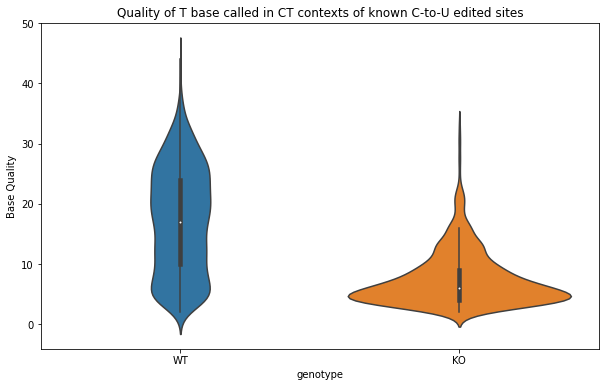

In [12]:
plt.figure(figsize=(10,6))
sn.violinplot(data=df, x="genotype", y="T_qual")
plt.title("Quality of T base called in CT contexts of known C-to-U edited sites")
plt.ylabel("Base Quality")
plt.show()

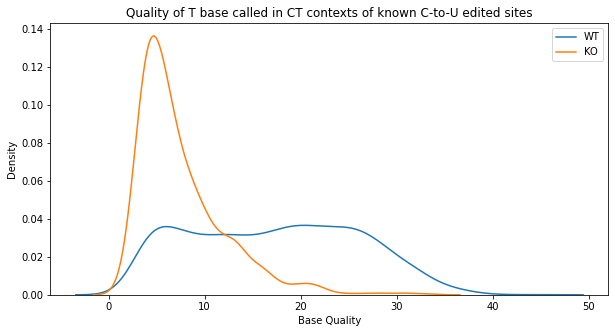

In [13]:
plt.figure(figsize=(10,5))
sn.kdeplot(WT_T_qual, label="WT")
sn.kdeplot(KO_T_qual, label="KO")
plt.xlabel("Base Quality")
plt.title("Quality of T base called in CT contexts of known C-to-U edited sites")
plt.legend()
plt.show()

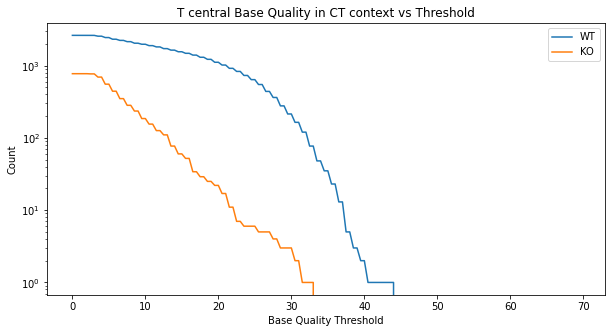

In [14]:
WT_above_threshold = []
KO_above_threshold = []
thresholds = []

for t in np.arange(0, 70, 0.5):
    thresholds.append(t)
    WT_above_threshold.append(df[(df["genotype"] == "WT")&(df["T_qual"] >= t)].shape[0])
    KO_above_threshold.append(df[(df["genotype"] == "KO")&(df["T_qual"] >= t)].shape[0])

plt.figure(figsize=(10,5))
plt.plot(thresholds, WT_above_threshold, label="WT")
plt.plot(thresholds, KO_above_threshold, label="KO")
plt.title("T central Base Quality in CT context vs Threshold")
plt.legend()
plt.xlabel("Base Quality Threshold")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

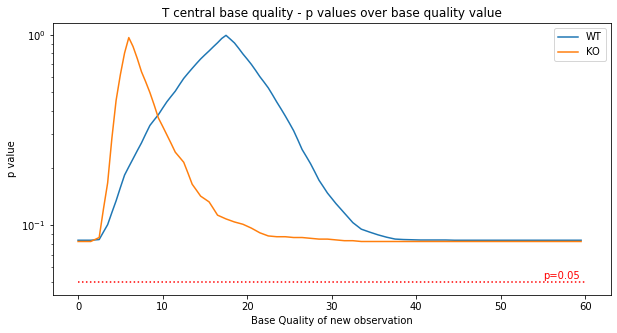

In [15]:
p_WT = []
p_KO = []
quals = []
for qual in np.arange(0,60, 0.5):
    quals.append(qual)
    stat, p = mannwhitneyu(WT_T_qual, [qual])
    p_WT.append(p)
    stat, p = mannwhitneyu(KO_T_qual, [qual])
    p_KO.append(p)

plt.figure(figsize=(10,5))
plt.plot(quals, p_WT, label="WT")
plt.plot(quals, p_KO, label="KO")
plt.title("T central base quality - p values over base quality value")
plt.legend()
plt.xlabel("Base Quality of new observation")
plt.ylabel("p value")
plt.yscale("log")
plt.hlines(0.05, 0, 60, linestyles="dotted", colors="red")
plt.text(55, 0.052, "p=0.05", c="red")
plt.show()

## General Overview

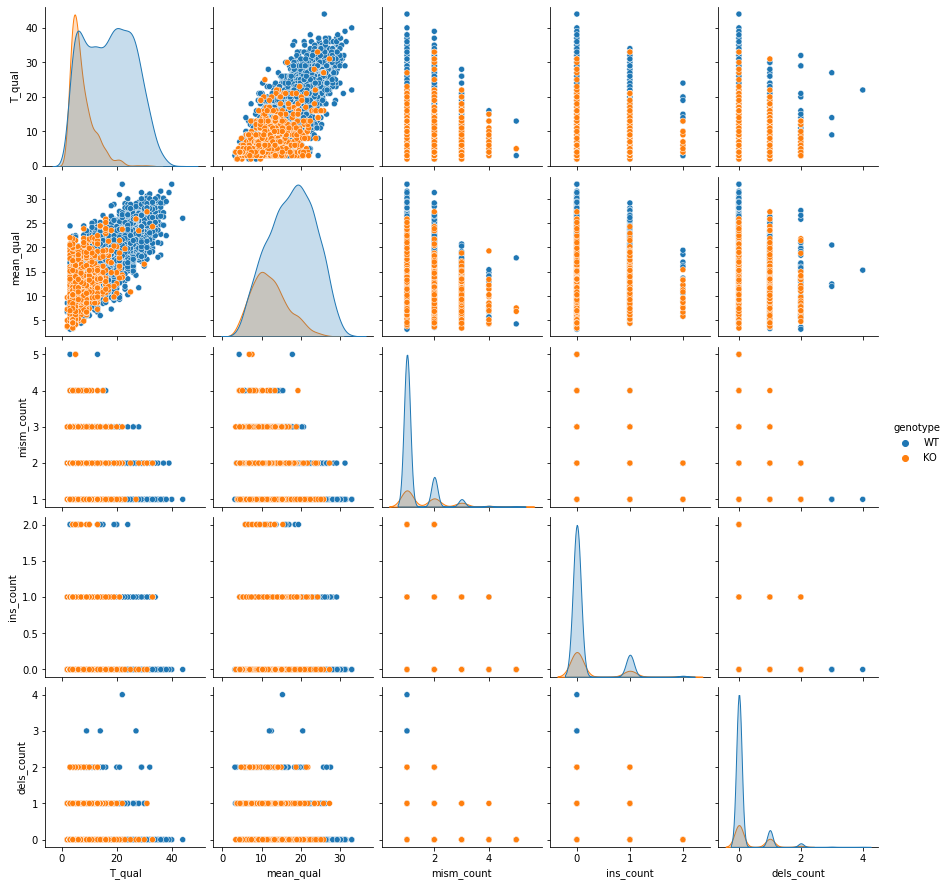

In [16]:
sn.pairplot(pd.DataFrame(df.iloc[:,:-1].values, columns=df.iloc[:, :-1].columns), hue="genotype")
plt.show()

## PCA analysis

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# stardardize dataset
sc = StandardScaler()

df_std = sc.fit_transform(df.iloc[:, :-2])

# perform simple PCA
pca = PCA(n_components=df_std.shape[1])

df_std_pca = pd.DataFrame(pca.fit_transform(df_std), columns=[f"PC{i}" for i in range(1,pca.n_components+1)])
df_std_pca["genotype"] = df.genotype.tolist()
df_std_pca["site"] = df.site.tolist()
df_std_pca

PC1       PC2       PC3       PC4       PC5 genotype  \
0     2.803753  3.412551  0.894678  0.837914 -0.480774       WT   
1     2.409238  3.419019  0.864174  1.017294 -0.343242       WT   
2     0.041999  0.120099 -0.021951 -0.895221  0.123113       WT   
3     1.860974  1.134326 -0.530740  0.931114 -0.227456       WT   
4    -0.626234  0.115310 -0.081928 -0.566059  0.105885       WT   
...        ...       ...       ...       ...       ...      ...   
3385  2.634124  3.423729  0.885993  0.901535 -0.288210       KO   
3386  0.221753  1.816181  0.359406  0.468960  0.719208       KO   
3387  0.980749 -2.496928  3.919807  0.932176  0.155932       KO   
3388  1.619305 -0.499089 -0.884353 -0.504087  0.177710       KO   
3389 -1.322924  0.161220 -0.117600 -0.304759  0.896773       KO   

                site  
0       chr1:4915683  
1       chr1:4915683  
2       chr1:4915683  
3       chr1:4915683  
4       chr1:4915683  
...              ...  
3385  chrX:141022422  
3386  chrX:141022422  
3387  chrX:158170617  
3388  chrX:158170617  
3389  chrX:158170617  

[3390 rows x 7 columns]

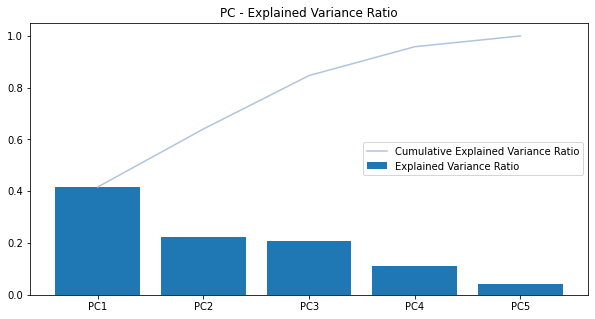

In [18]:
# plot PCs explained variance
plt.figure(figsize=(10,5))
plt.bar([f"PC{i}" for i in range(1, pca.n_components+1)], pca.explained_variance_ratio_, label="Explained Variance Ratio")
plt.plot(np.cumsum(pca.explained_variance_ratio_), label="Cumulative Explained Variance Ratio", c="lightsteelblue")
plt.title("PC - Explained Variance Ratio")
plt.legend(loc="right")
plt.show()

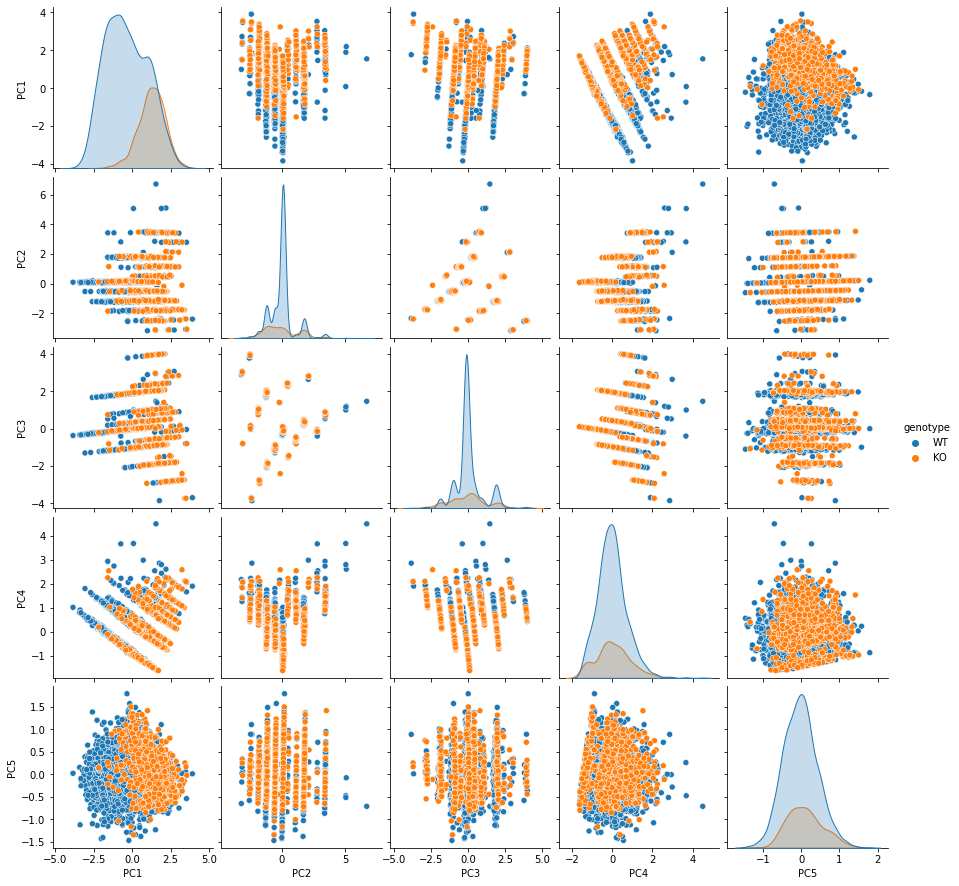

In [19]:
# plot first 3 PCs
sn.pairplot(data=df_std_pca.iloc[:,:-1], hue="genotype")
plt.show()

In [20]:
# get and visualize components and weights to understand features importance.-
PCs = pd.DataFrame(pca.components_, columns=df.iloc[:, :-2].columns, index=df_std_pca.columns[:-2]).T
PCs

PC1       PC2       PC3       PC4       PC5
T_qual     -0.626576 -0.046070 -0.078179  0.375525 -0.676868
mean_qual  -0.640666  0.042218 -0.032803  0.240288  0.727290
mism_count  0.340413 -0.399638 -0.615489  0.578562  0.104155
ins_count   0.121790 -0.506730  0.762291  0.381137  0.045157
dels_count  0.257366  0.761321  0.181377  0.566784  0.003440

## t-SNE

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE()

df_std_tsne = pd.DataFrame(tsne.fit_transform(df_std), columns=[f"tSNE{i}" for i in range(1,tsne.n_components+1)])
df_std_tsne["genotype"] = df.genotype.tolist()
df_std_tsne["site"] = df.site.tolist()
df_std_tsne

/home/adri/miniconda3/envs/sgd_oc_svm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/adri/miniconda3/envs/sgd_oc_svm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tSNE1      tSNE2 genotype            site
0    -34.752666  -2.219354       WT    chr1:4915683
1    -35.852158  -1.235333       WT    chr1:4915683
2     -2.954981 -39.958771       WT    chr1:4915683
3    -68.680710  -1.868231       WT    chr1:4915683
4     -3.565686 -21.822138       WT    chr1:4915683
...         ...        ...      ...             ...
3385 -34.877956  -1.473809       KO  chrX:141022422
3386 -58.886131  21.698513       KO  chrX:141022422
3387  38.752041  62.866432       KO  chrX:158170617
3388  73.126511  -7.071247       KO  chrX:158170617
3389 -16.527040  -3.735771       KO  chrX:158170617

[3390 rows x 4 columns]

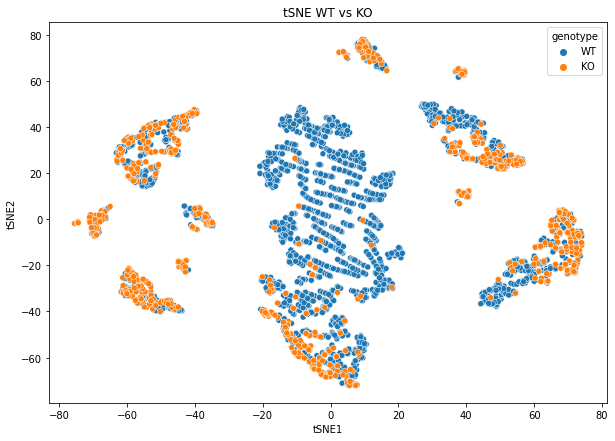

In [22]:
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne.iloc[:,:-1], x="tSNE1", y="tSNE2", hue="genotype")
plt.title("tSNE WT vs KO")
plt.show()

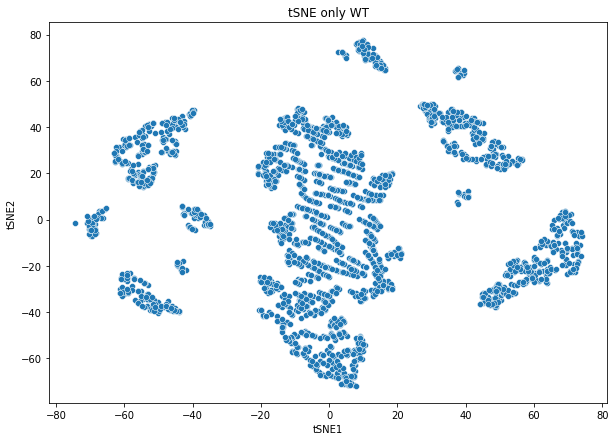

In [23]:
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[df_std_tsne["genotype"]=="WT"].iloc[:,:-1], x="tSNE1", y="tSNE2")
plt.title("tSNE only WT")
plt.show()

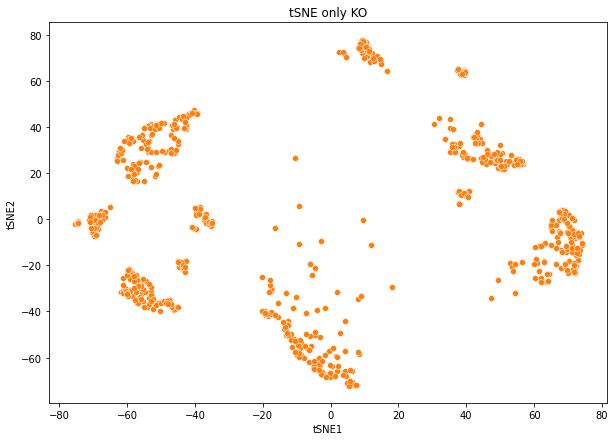

In [24]:
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[df_std_tsne["genotype"]=="KO"].iloc[:,:-1], x="tSNE1", y="tSNE2", color=sn.color_palette()[1])
plt.title("tSNE only KO")
plt.show()

### 5-mers analysis on reference context analysis
The goal of this section is to understands if sites with a similar k-mer fall within the same cluster seen in the t-SNE analysis.

In [25]:
df_std_tsne["ref_context"] = WT_ref_contexts + KO_ref_contexts
df_std_tsne

tSNE1      tSNE2 genotype            site ref_context
0    -34.752666  -2.219354       WT    chr1:4915683       CACAT
1    -35.852158  -1.235333       WT    chr1:4915683       CACAT
2     -2.954981 -39.958771       WT    chr1:4915683       CACAT
3    -68.680710  -1.868231       WT    chr1:4915683       CACAT
4     -3.565686 -21.822138       WT    chr1:4915683       CACAT
...         ...        ...      ...             ...         ...
3385 -34.877956  -1.473809       KO  chrX:141022422       AACTA
3386 -58.886131  21.698513       KO  chrX:141022422       AACTA
3387  38.752041  62.866432       KO  chrX:158170617       TTCTA
3388  73.126511  -7.071247       KO  chrX:158170617       TTCTA
3389 -16.527040  -3.735771       KO  chrX:158170617       TTCTA

[3390 rows x 5 columns]

In [26]:
df_std_tsne["ref_context"].value_counts()

TACTT    291
GACTT    272
CACAT    191
TACTG    181
TACAC    172
        ... 
TTCCC      2
AGCGC      1
CTCAT      1
TTCGC      1
AACTC      1
Name: ref_context, Length: 75, dtype: int64

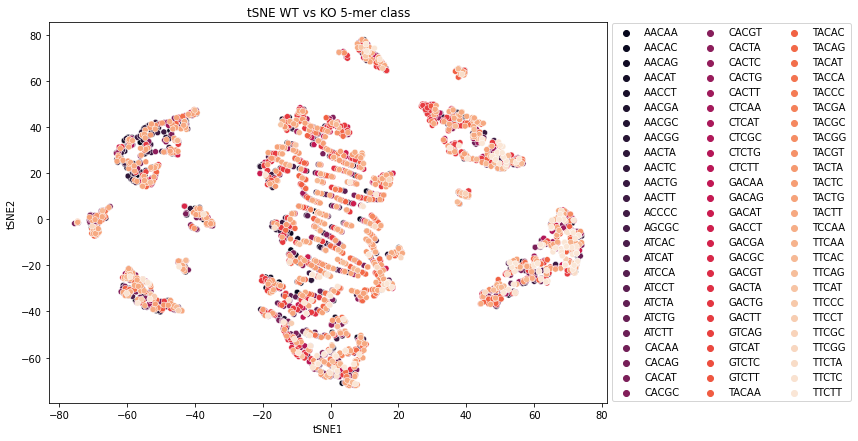

In [27]:
# visualize tSNE with ref_context (5-mer) class WT and KO
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[["tSNE1", "tSNE2", "ref_context"]].sort_values("ref_context"), 
               x="tSNE1", 
               y="tSNE2", 
               hue="ref_context", 
               palette="rocket")
plt.title("tSNE WT vs KO 5-mer class")
plt.legend(bbox_to_anchor=(1, 1.01), ncol=3)
plt.show()

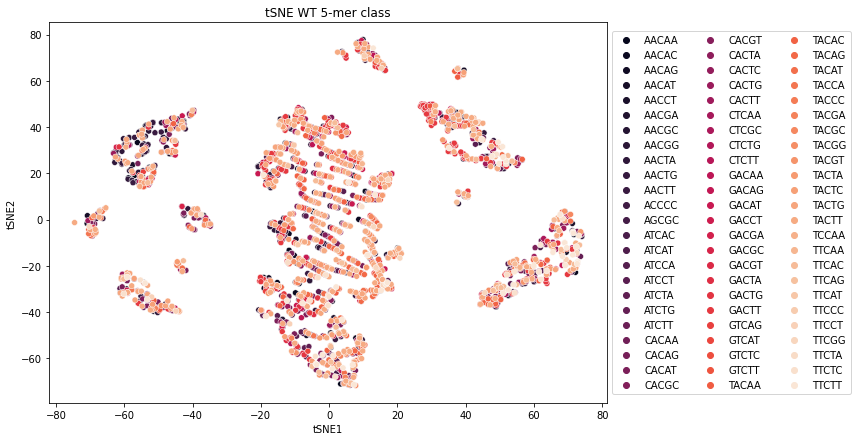

In [28]:
# visualize tSNE with ref_context (5-mer) class WT
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne.query("genotype == 'WT'")[["tSNE1", "tSNE2", "ref_context"]].sort_values("ref_context"), 
               x="tSNE1", 
               y="tSNE2", 
               hue="ref_context", 
               palette="rocket")
plt.title("tSNE WT 5-mer class")
plt.legend(bbox_to_anchor=(1, 0.99), ncol=3)
plt.show()

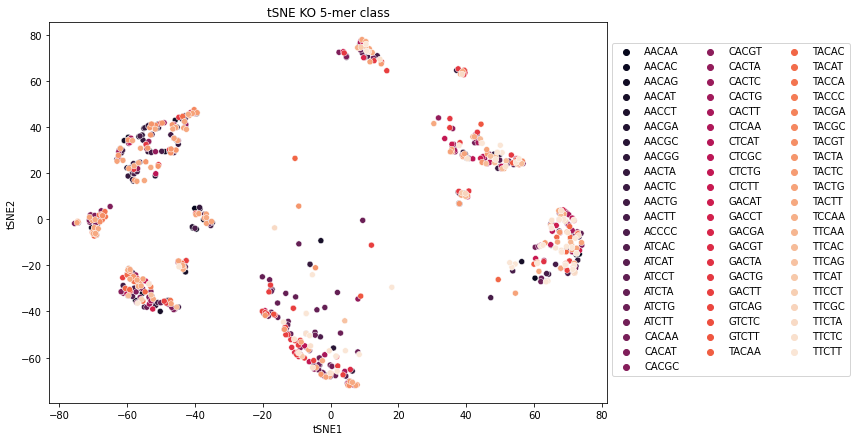

In [29]:
# visualize tSNE with ref_context (5-mer) class KO
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne.query("genotype == 'KO'")[["tSNE1", "tSNE2", "ref_context"]].sort_values("ref_context"), 
               x="tSNE1", 
               y="tSNE2", 
               hue="ref_context", 
               palette="rocket")
plt.title("tSNE KO 5-mer class")
plt.legend(bbox_to_anchor=(1, 0.96), ncol=3)
plt.show()

In [30]:
# plot interactive scatterplot with pyplot express
import plotly.express as px
fig = px.scatter(df_std_tsne.sort_values("ref_context"), 
                 x="tSNE1", 
                 y="tSNE2", 
                 color="ref_context")

# put title inside figure
fig.update_layout(
    title={
        'text': "tSNE WT vs KO 5-mer class",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

The composition of each cluster showed into t-SNE in terms of 5-mer is quite eterogeneous. This lead to think that there isn't a clear pattern that is brought by a specific 5-mer.

### SVM One Class model: first approach without fine tuning on whole KO dataset
Now, I'm going to build a Support Vector Machine One Class on the entire KO dataset in order to obtain a first, expeditious understanding of the feasibility of this model to take trace of novelty detection on KO sites. The sites classified as novelty should be the real T within a CT context. This could be used to decrease the I type error when calling a C-to-U editing site since Nanopore ONT direct-RNA sequencing seem to call T also in KO.

In [31]:
# importing SVM OC module and class
from sklearn.svm import OneClassSVM

sc = StandardScaler()

X = sc.fit_transform(df.iloc[:,:-2].values)
X_train = X[df[df["genotype"] == "WT"].shape[0]:] # training on KO sites
X_test = X[:df[df["genotype"] == "WT"].shape[0]] # testing on WT sites (some of those should be classified as novelty)

In [32]:
# training the model
svm_oc = OneClassSVM(kernel="rbf")

svm_oc.fit(X_train)
y_hat_KO = svm_oc.predict(X_train)
y_hat_KO

array([-1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,
        1, -1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1,  1,  1,
       -1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1,  1,
       -1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1,
       -1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
       -1,  1, -1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,
        1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,
        1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1,
        1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1,
        1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1, -1,
        1,  1, -1, -1,  1

In [33]:
# quickly predict on WT
y_hat_WT = svm_oc.predict(X_test)
y_hat_WT

array([-1, -1,  1, ...,  1, -1, -1])

In [34]:
# print predicted results for KO sites
np.unique(y_hat_KO, return_counts=True)

(array([-1,  1]), array([387, 385]))

In [35]:
# print predicted results for WT sites 
np.unique(y_hat_WT, return_counts=True)

(array([-1,  1]), array([1941,  677]))

In [36]:
df_std_tsne

tSNE1      tSNE2 genotype            site ref_context
0    -34.752666  -2.219354       WT    chr1:4915683       CACAT
1    -35.852158  -1.235333       WT    chr1:4915683       CACAT
2     -2.954981 -39.958771       WT    chr1:4915683       CACAT
3    -68.680710  -1.868231       WT    chr1:4915683       CACAT
4     -3.565686 -21.822138       WT    chr1:4915683       CACAT
...         ...        ...      ...             ...         ...
3385 -34.877956  -1.473809       KO  chrX:141022422       AACTA
3386 -58.886131  21.698513       KO  chrX:141022422       AACTA
3387  38.752041  62.866432       KO  chrX:158170617       TTCTA
3388  73.126511  -7.071247       KO  chrX:158170617       TTCTA
3389 -16.527040  -3.735771       KO  chrX:158170617       TTCTA

[3390 rows x 5 columns]

In [37]:
y_hat = y_hat_WT.tolist() + y_hat_KO.tolist()
y_hat

[-1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -

In [38]:
# decode label predicted as -1 --> T real, +1 --> T false (to be escluded)
labels = {-1:"T real", 1:"T false"}
labels

{-1: 'T real', 1: 'T false'}

In [39]:
y_hat_decoded = []
for prediction in y_hat:
    y_hat_decoded.append(labels[prediction])
y_hat_decoded

['T real',
 'T real',
 'T false',
 'T false',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T false',
 'T real',
 'T false',
 'T false',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T false',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T false',
 'T real',
 'T false',
 'T real',
 'T false',
 'T real',
 'T real',
 'T false',
 'T false',
 'T real',
 'T real',
 'T false',
 'T real',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T real',
 'T false',
 'T false',
 'T real',
 'T real',
 'T false',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T real',
 'T r

In [40]:
# appending predicted labels to df_std_tsne to visulize afterwards
df_std_tsne["y_hat"] = y_hat_decoded
df_std_tsne

tSNE1      tSNE2 genotype            site ref_context    y_hat
0    -34.752666  -2.219354       WT    chr1:4915683       CACAT   T real
1    -35.852158  -1.235333       WT    chr1:4915683       CACAT   T real
2     -2.954981 -39.958771       WT    chr1:4915683       CACAT  T false
3    -68.680710  -1.868231       WT    chr1:4915683       CACAT  T false
4     -3.565686 -21.822138       WT    chr1:4915683       CACAT   T real
...         ...        ...      ...             ...         ...      ...
3385 -34.877956  -1.473809       KO  chrX:141022422       AACTA   T real
3386 -58.886131  21.698513       KO  chrX:141022422       AACTA   T real
3387  38.752041  62.866432       KO  chrX:158170617       TTCTA   T real
3388  73.126511  -7.071247       KO  chrX:158170617       TTCTA  T false
3389 -16.527040  -3.735771       KO  chrX:158170617       TTCTA   T real

[3390 rows x 6 columns]

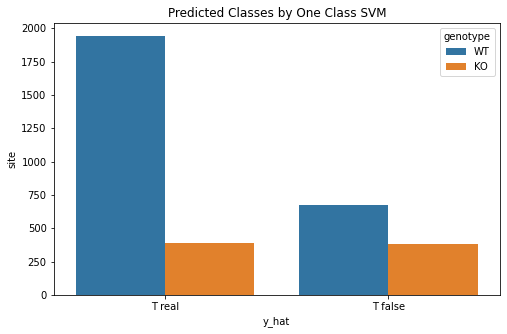

In [41]:
plt.figure(figsize=(8,5))
sn.barplot(data=df_std_tsne.groupby(["genotype", "y_hat"]).count().sort_index(ascending=False).reset_index(), 
           x="y_hat", 
           y="site", 
           hue="genotype")
plt.title("Predicted Classes by One Class SVM")
plt.show()

In [42]:
df_std_tsne.groupby(["genotype", "y_hat"]).count().sort_index(ascending=False)

tSNE1  tSNE2  site  ref_context
genotype y_hat                                   
WT       T real    1941   1941  1941         1941
         T false    677    677   677          677
KO       T real     387    387   387          387
         T false    385    385   385          385

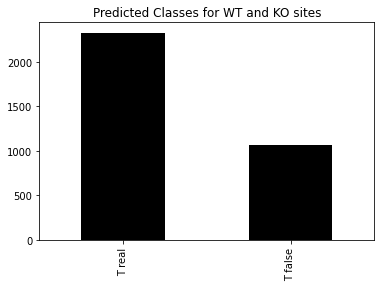

In [43]:
df_std_tsne.y_hat.value_counts().plot(kind="bar", color="Black")
plt.title("Predicted Classes for WT and KO sites")
plt.show()

In [44]:
df_std_tsne.y_hat.value_counts()

T real     2328
T false    1062
Name: y_hat, dtype: int64

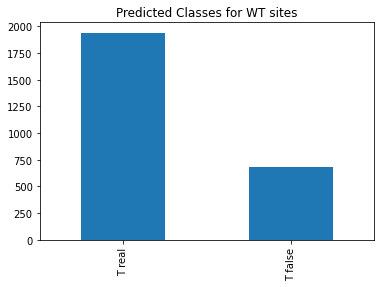

In [45]:
df_std_tsne[df_std_tsne["genotype"]=="WT"].y_hat.value_counts().plot(kind="bar")
plt.title("Predicted Classes for WT sites")
plt.show()

In [46]:
df_std_tsne[df_std_tsne["genotype"]=="WT"].y_hat.value_counts()

T real     1941
T false     677
Name: y_hat, dtype: int64

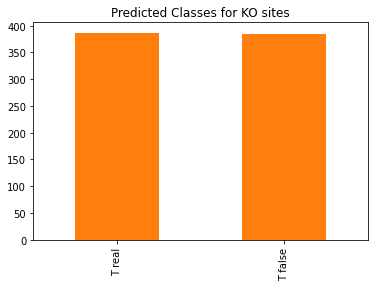

In [47]:
df_std_tsne[df_std_tsne["genotype"]=="KO"].y_hat.value_counts().plot(kind="bar", color=sn.color_palette()[1])
plt.title("Predicted Classes for KO sites")
plt.show()

In [48]:
df_std_tsne[df_std_tsne["genotype"]=="KO"].y_hat.value_counts()

T real     387
T false    385
Name: y_hat, dtype: int64

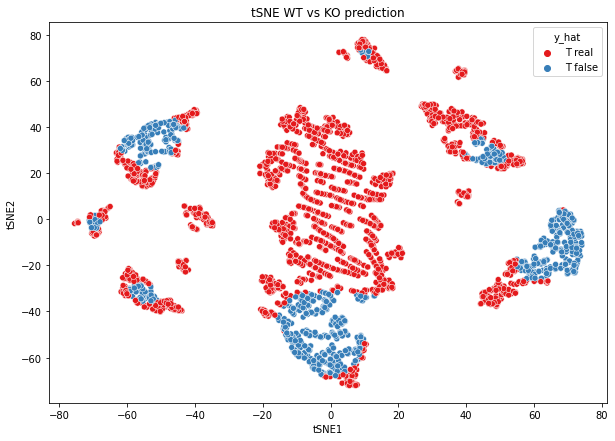

In [49]:
# visualize tSNE with predicted labels 
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[["tSNE1", "tSNE2", "y_hat"]], x="tSNE1", y="tSNE2", hue="y_hat", palette="Set1")
plt.title("tSNE WT vs KO prediction")
plt.show()

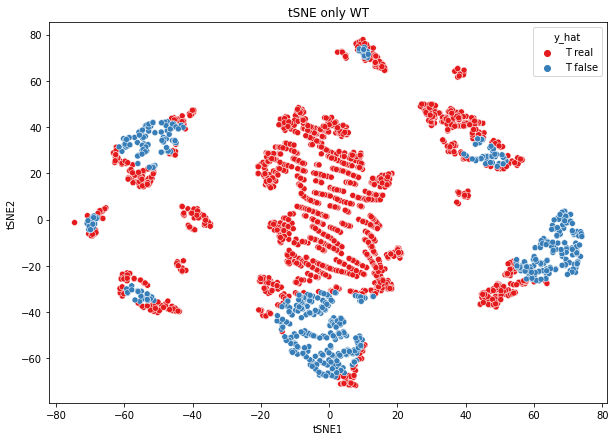

In [50]:
# visualize tSNE with predicted labels
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[df_std_tsne["genotype"]=="WT"][["tSNE1", "tSNE2", "y_hat"]].sort_values("y_hat", 
                                                                                                        ascending=False), 
               x="tSNE1", 
               y="tSNE2", 
               hue="y_hat", 
               palette="Set1")
plt.title("tSNE only WT")
plt.show()

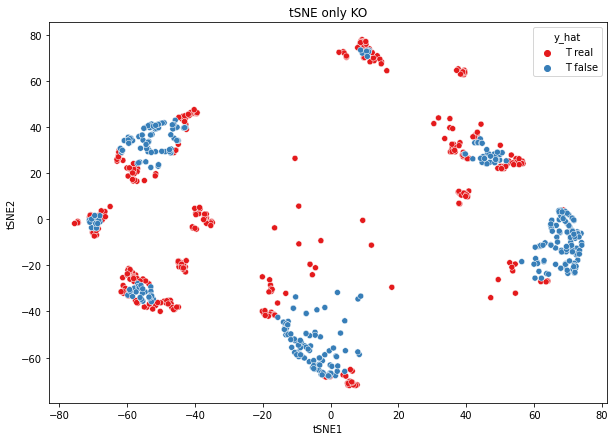

In [51]:
# visualize tSNE with predicted labels
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[df_std_tsne["genotype"]=="KO"][["tSNE1", "tSNE2", "y_hat"]].sort_values("y_hat", 
                                                                                                        ascending=False), 
               x="tSNE1", 
               y="tSNE2", 
               hue="y_hat",
               palette="Set1")
plt.title("tSNE only KO")
plt.show()

Very well! The classifier One Class SVM is able to perform nicely on these data. Let's start with fine tuning of hyperparameters.

## Fine tune the OC-SVM model
Fine tuning of the SVM One-Class classifier via Cross Validation and Grid Search. All the KO samples will be labelled as +1 (regula observation). In the end we are trying to model the baseline error on the CT context using known T less sites retrieved from known edited position from KO run.

In [52]:
# import train-test split module
from sklearn.model_selection import train_test_split

# import gridsearch CV from sklearn library
from sklearn.model_selection import GridSearchCV

# create X_train_KO, X_test_KO, and X_WT datasets and standardize data all together
sc = StandardScaler()

X = sc.fit_transform(df.iloc[:,:-2].values)

X_KO = X[df[df["genotype"] == "WT"].shape[0]:] # KO sites
X_KO_train, X_KO_test = train_test_split(X[df[df["genotype"] == "WT"].shape[0]:], test_size=0.3) # train-test split
X_WT = X[:df[df["genotype"] == "WT"].shape[0]] # WT sites

y_KO_train = np.array([1 for i in range(X_KO_train.shape[0])])
y_KO_test = np.array([1 for i in range(X_KO_test.shape[0])])

print("# Dataset sizes:")
print("\tX_KO_train size:", X_KO_train.shape)
print("\tX_KO_test size:", X_KO_test.shape)
print("\tX_WT size:", X_WT.shape)
print("\ty_KO_train size:", y_KO_train.shape)
print("\ty_KO_test size:", y_KO_test.shape)
print()

# Dataset sizes:
	X_KO_train size: (540, 5)
	X_KO_test size: (232, 5)
	X_WT size: (2618, 5)
	y_KO_train size: (540,)
	y_KO_test size: (232,)



In [53]:
# start grid search to find best hyperparameters
parameters = {"nu":[0.01, 0.09, 0.1, 0.9],
              "gamma":[0.1, 1, 3, 10, 30, 100, 300, 1000, 3000]}

svc = OneClassSVM()

clf = GridSearchCV(svc, parameters, cv=10, verbose=3, scoring="accuracy", return_train_score=True)
clf.fit(X_KO_train, y_KO_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END gamma=0.1, nu=0.01;, score=(train=0.981, test=0.963) total time=   0.0s
[CV 2/10] END gamma=0.1, nu=0.01;, score=(train=0.977, test=0.981) total time=   0.0s
[CV 3/10] END gamma=0.1, nu=0.01;, score=(train=0.984, test=0.963) total time=   0.0s
[CV 4/10] END gamma=0.1, nu=0.01;, score=(train=0.981, test=1.000) total time=   0.0s
[CV 5/10] END gamma=0.1, nu=0.01;, score=(train=0.979, test=0.963) total time=   0.0s
[CV 6/10] END gamma=0.1, nu=0.01;, score=(train=0.984, test=0.926) total time=   0.0s
[CV 7/10] END gamma=0.1, nu=0.01;, score=(train=0.979, test=0.870) total time=   0.0s
[CV 8/10] END gamma=0.1, nu=0.01;, score=(train=0.981, test=0.981) total time=   0.0s
[CV 9/10] END gamma=0.1, nu=0.01;, score=(train=0.986, test=0.963) total time=   0.0s
[CV 10/10] END gamma=0.1, nu=0.01;, score=(train=0.981, test=1.000) total time=   0.0s
[CV 1/10] END gamma=0.1, nu=0.09;, score=(train=0.909, test=0.926) total tim

[CV 8/10] END gamma=3, nu=0.1;, score=(train=0.798, test=0.704) total time=   0.0s
[CV 9/10] END gamma=3, nu=0.1;, score=(train=0.807, test=0.722) total time=   0.0s
[CV 10/10] END gamma=3, nu=0.1;, score=(train=0.827, test=0.667) total time=   0.0s
[CV 1/10] END gamma=3, nu=0.9;, score=(train=0.101, test=0.185) total time=   0.0s
[CV 2/10] END gamma=3, nu=0.9;, score=(train=0.099, test=0.148) total time=   0.0s
[CV 3/10] END gamma=3, nu=0.9;, score=(train=0.103, test=0.037) total time=   0.0s
[CV 4/10] END gamma=3, nu=0.9;, score=(train=0.099, test=0.037) total time=   0.0s
[CV 5/10] END gamma=3, nu=0.9;, score=(train=0.088, test=0.093) total time=   0.0s
[CV 6/10] END gamma=3, nu=0.9;, score=(train=0.105, test=0.074) total time=   0.0s
[CV 7/10] END gamma=3, nu=0.9;, score=(train=0.101, test=0.074) total time=   0.0s
[CV 8/10] END gamma=3, nu=0.9;, score=(train=0.105, test=0.167) total time=   0.0s
[CV 9/10] END gamma=3, nu=0.9;, score=(train=0.099, test=0.056) total time=   0.0s
[CV

[CV 6/10] END gamma=100, nu=0.01;, score=(train=0.605, test=0.148) total time=   0.0s
[CV 7/10] END gamma=100, nu=0.01;, score=(train=0.574, test=0.074) total time=   0.0s
[CV 8/10] END gamma=100, nu=0.01;, score=(train=0.578, test=0.167) total time=   0.0s
[CV 9/10] END gamma=100, nu=0.01;, score=(train=0.632, test=0.074) total time=   0.0s
[CV 10/10] END gamma=100, nu=0.01;, score=(train=0.605, test=0.111) total time=   0.0s
[CV 1/10] END gamma=100, nu=0.09;, score=(train=0.640, test=0.074) total time=   0.0s
[CV 2/10] END gamma=100, nu=0.09;, score=(train=0.580, test=0.148) total time=   0.0s
[CV 3/10] END gamma=100, nu=0.09;, score=(train=0.510, test=0.111) total time=   0.0s
[CV 4/10] END gamma=100, nu=0.09;, score=(train=0.580, test=0.074) total time=   0.0s
[CV 5/10] END gamma=100, nu=0.09;, score=(train=0.510, test=0.148) total time=   0.0s
[CV 6/10] END gamma=100, nu=0.09;, score=(train=0.599, test=0.111) total time=   0.0s
[CV 7/10] END gamma=100, nu=0.09;, score=(train=0.519

[CV 6/10] END gamma=1000, nu=0.1;, score=(train=0.626, test=0.056) total time=   0.0s
[CV 7/10] END gamma=1000, nu=0.1;, score=(train=0.453, test=0.000) total time=   0.0s
[CV 8/10] END gamma=1000, nu=0.1;, score=(train=0.461, test=0.037) total time=   0.0s
[CV 9/10] END gamma=1000, nu=0.1;, score=(train=0.605, test=0.056) total time=   0.0s
[CV 10/10] END gamma=1000, nu=0.1;, score=(train=0.471, test=0.037) total time=   0.0s
[CV 1/10] END gamma=1000, nu=0.9;, score=(train=0.640, test=0.037) total time=   0.0s
[CV 2/10] END gamma=1000, nu=0.9;, score=(train=0.383, test=0.000) total time=   0.0s
[CV 3/10] END gamma=1000, nu=0.9;, score=(train=0.126, test=0.019) total time=   0.0s
[CV 4/10] END gamma=1000, nu=0.9;, score=(train=0.391, test=0.037) total time=   0.0s
[CV 5/10] END gamma=1000, nu=0.9;, score=(train=0.498, test=0.019) total time=   0.0s
[CV 6/10] END gamma=1000, nu=0.9;, score=(train=0.560, test=0.019) total time=   0.0s
[CV 7/10] END gamma=1000, nu=0.9;, score=(train=0.189

GridSearchCV(cv=10, estimator=OneClassSVM(),
             param_grid={'gamma': [0.1, 1, 3, 10, 30, 100, 300, 1000, 3000],
                         'nu': [0.01, 0.09, 0.1, 0.9]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [54]:
# best parameters
clf.best_params_

{'gamma': 0.1, 'nu': 0.01}

In [55]:
# print best estimator
clf.best_estimator_

OneClassSVM(gamma=0.1, nu=0.01)

In [56]:
# validation accuracy with best parameters
clf.best_score_

0.961111111111111

In [57]:
# plot validation matrices
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_gamma', 'param_nu', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [58]:
# Extracting CV results.
#For each fold (5 folds) extract scores of train and test sets as mean, and standard deviation
# of the 88 combinations of hyper-parameters.
cvOutput_param = pd.DataFrame(clf.cv_results_["params"])
cvOutput_param["TrainMean"] = clf.cv_results_["mean_train_score"]
cvOutput_param["TrainStd"] = clf.cv_results_["std_train_score"]
cvOutput_param["TestMean"] = clf.cv_results_["mean_test_score"]
cvOutput_param["TestStd"] = clf.cv_results_["std_test_score"]
cvOutput_param

gamma    nu  TrainMean  TrainStd  TestMean   TestStd
0      0.1  0.01   0.981481  0.002254  0.961111  0.036524
1      0.1  0.09   0.909671  0.002675  0.905556  0.047177
2      0.1  0.10   0.898148  0.001897  0.890741  0.044174
3      0.1  0.90   0.099383  0.000943  0.098148  0.037997
4      1.0  0.01   0.891152  0.005924  0.812963  0.044943
5      1.0  0.09   0.894033  0.007023  0.807407  0.046259
6      1.0  0.10   0.893827  0.007373  0.805556  0.046296
7      1.0  0.90   0.099588  0.003343  0.107407  0.050918
8      3.0  0.01   0.796708  0.009284  0.662963  0.056047
9      3.0  0.09   0.821193  0.008752  0.662963  0.068693
10     3.0  0.10   0.816461  0.013392  0.666667  0.061975
11     3.0  0.90   0.100000  0.004432  0.090741  0.053319
12    10.0  0.01   0.661523  0.021049  0.424074  0.077446
13    10.0  0.09   0.690535  0.023228  0.440741  0.073981
14    10.0  0.10   0.696914  0.019127  0.438889  0.075017
15    10.0  0.90   0.100617  0.004262  0.083333  0.018976
16    30.0  0.01   0.557819  0.019980  0.229630  0.046259
17    30.0  0.09   0.569959  0.023801  0.246296  0.049030
18    30.0  0.10   0.616667  0.020680  0.237037  0.037771
19    30.0  0.90   0.109053  0.006699  0.062963  0.020621
20   100.0  0.01   0.603498  0.018497  0.112963  0.038356
21   100.0  0.09   0.558848  0.040876  0.107407  0.033945
22   100.0  0.10   0.598148  0.021225  0.109259  0.043390
23   100.0  0.90   0.125720  0.010749  0.040741  0.016144
24   300.0  0.01   0.450617  0.024049  0.053704  0.034595
25   300.0  0.09   0.450000  0.041276  0.042593  0.037997
26   300.0  0.10   0.604115  0.048694  0.059259  0.024568
27   300.0  0.90   0.153498  0.009919  0.024074  0.018611
28  1000.0  0.01   0.483745  0.026661  0.040741  0.023130
29  1000.0  0.09   0.526132  0.078005  0.040741  0.021596
30  1000.0  0.10   0.519342  0.058577  0.031481  0.018611
31  1000.0  0.90   0.404527  0.184895  0.027778  0.022299
32  3000.0  0.01   0.676543  0.024756  0.042593  0.021990
33  3000.0  0.09   0.468930  0.056623  0.027778  0.022299
34  3000.0  0.10   0.378601  0.062809  0.016667  0.022605
35  3000.0  0.90   0.512140  0.110601  0.029630  0.020621

In [59]:
# print CV results for the 
cvOutput_param[(cvOutput_param["gamma"]==clf.best_params_["gamma"]) & (cvOutput_param["nu"]==clf.best_params_["nu"])]

gamma    nu  TrainMean  TrainStd  TestMean   TestStd
0    0.1  0.01   0.981481  0.002254  0.961111  0.036524

## SVM One Class model: evaluate on test set using best parameters
Assessing quickly the ability of the OC-SVM to generalize on unknown KO's and WT test data.

In [60]:
# retrieve best estimator
oc_svm = clf.best_estimator_

# retrain it on the entire X_KO_train dataset
oc_svm.fit(X_KO_train)
print("OC-SVM paramters:", oc_svm.get_params())
print()

# predict classes for KO train and test datasets
y_hat_KO_train = oc_svm.predict(X_KO_train)
y_hat_KO_test = oc_svm.predict(X_KO_test)

# quickly predict on WT dataset
y_hat_WT = oc_svm.predict(X_WT)

# print predicted results for KO sites
print("# KO train")
KO_train_abnormal = y_hat_KO_train.tolist().count(-1)
KO_train_regular = y_hat_KO_train.tolist().count(1)
print(f"\t-1 (abnomal) count: {KO_train_abnormal}")
print(f"\t+1 (regular) count: {KO_train_regular}")
print("\t-1 (abnormal) class:", round( 100 * (KO_train_abnormal / (KO_train_abnormal + KO_train_regular)), 2), "%")
print("\t+1 (regular) class:", round( 100 * (KO_train_regular / (KO_train_abnormal + KO_train_regular)), 2), "%")
if KO_train_regular != 0:    
    KO_train_ratio = round(KO_train_abnormal / KO_train_regular, 2)
    print("\tRatio -1/+1 classes:", KO_train_ratio)
else:
    KO_train_ratio = "inf."
    print("\tRatio -1/+1 classes:", KO_train_ratio)
    
print()
print("# KO test")
KO_test_abnormal = y_hat_KO_test.tolist().count(-1)
KO_test_regular = y_hat_KO_test.tolist().count(1)
print(f"\t-1 (abnomal) count: {KO_test_abnormal}")
print(f"\t+1 (regular) count: {KO_test_regular}")
print("\t-1 (abnormal) class:", round( 100 * (KO_test_abnormal / (KO_test_abnormal + KO_test_regular)), 2), "%")
print("\t+1 (regular) class:", round( 100 * (KO_test_regular / (KO_test_abnormal + KO_test_regular)), 2), "%")
if KO_test_regular != 0:    
    KO_test_ratio = round(KO_test_abnormal / KO_test_regular, 2)
    print("\tRatio -1/+1 classes:", KO_test_ratio)
else:
    KO_test_ratio = "inf."
    print("\tRatio -1/+1 classes:", KO_test_ratio)

# print predicted results for WT sites 
print()
print("# WT")
WT_abnormal = y_hat_WT.tolist().count(-1)
WT_regular = y_hat_WT.tolist().count(1)
print(f"\t-1 (abnomal) count: {WT_abnormal}")
print(f"\t+1 (regular) count: {WT_regular}")
print("\t-1 (abnormal) class:", round( 100 * (WT_abnormal / (WT_abnormal + WT_regular)), 2), "%")
print("\t+1 (regular) class:", round( 100 * (WT_regular / (WT_abnormal + WT_regular)), 2), "%")
if WT_regular != 0:
    WT_ratio = round(WT_abnormal / WT_regular, 2)
    print("\tRatio -1/+1 classes:", WT_ratio)
else:
    KO_test_ratio = "inf."
    print("\tRatio -1/+1 classes:", WT_ratio)
 
if WT_ratio != "inf." and KO_test_ratio != "inf.":
    if KO_test_ratio != 0:
        print("\nRATIO WT / KO:", WT_ratio/KO_test_ratio)
    else:
        print("\nRATIO WT / KO: inf.")

OC-SVM paramters: {'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.01, 'shrinking': True, 'tol': 0.001, 'verbose': False}

# KO train
	-1 (abnomal) count: 10
	+1 (regular) count: 530
	-1 (abnormal) class: 1.85 %
	+1 (regular) class: 98.15 %
	Ratio -1/+1 classes: 0.02

# KO test
	-1 (abnomal) count: 7
	+1 (regular) count: 225
	-1 (abnormal) class: 3.02 %
	+1 (regular) class: 96.98 %
	Ratio -1/+1 classes: 0.03

# WT
	-1 (abnomal) count: 703
	+1 (regular) count: 1915
	-1 (abnormal) class: 26.85 %
	+1 (regular) class: 73.15 %
	Ratio -1/+1 classes: 0.37

RATIO WT / KO: 12.333333333333334


In [61]:
# print accuracy on KO train and test sets
print("Final accuracy on KO train set:", round(KO_train_regular / (KO_train_abnormal + KO_train_regular),2))
print("Final accuracy on KO test set:", round(KO_test_regular / (KO_test_abnormal + KO_test_regular),2))

Final accuracy on KO train set: 0.98
Final accuracy on KO test set: 0.97


In [62]:
# visualize via tSNE the results of the final classifier
df_tsne_final = pd.concat([pd.DataFrame(X_WT), pd.DataFrame(X_KO_test)])
tsne_final = TSNE()
df_tsne_final = pd.DataFrame(tsne_final.fit_transform(df_tsne_final))
df_tsne_final.columns = ["tSNE1", "tSNE2"]

y_hat_final_decoded = []
# decode y_hat_final classes
for i in y_hat_WT.tolist() + y_hat_KO_test.tolist():
    y_hat_final_decoded.append(labels[i])

df_tsne_final["y_hat_final"] = y_hat_final_decoded
df_tsne_final

/home/adri/miniconda3/envs/sgd_oc_svm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/adri/miniconda3/envs/sgd_oc_svm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



tSNE1      tSNE2 y_hat_final
0     -9.126933  71.128395     T false
1     -9.872135  70.185287     T false
2    -29.183018  -9.317680     T false
3    -24.618156  31.091974     T false
4    -10.726223 -13.106991     T false
...         ...        ...         ...
2845  24.832579  30.425196     T false
2846 -56.135132  38.867733     T false
2847   1.558078  33.743301     T false
2848 -48.382271  49.307751     T false
2849  -0.333129  45.354206     T false

[2850 rows x 3 columns]

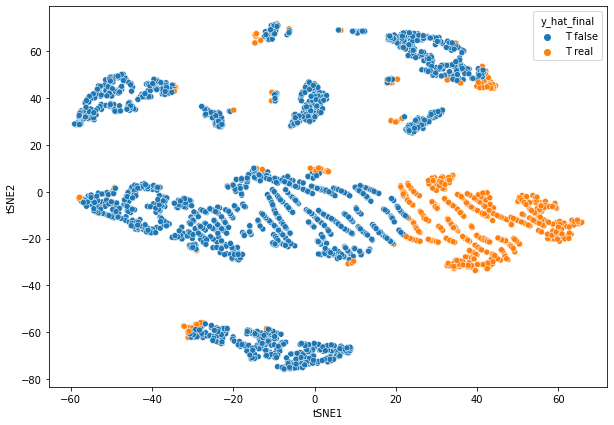

In [63]:
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_tsne_final, x="tSNE1", y="tSNE2", hue="y_hat_final")
plt.show()

The final classifier performed very well and found almost exclusively T real reads on CT sites from WT sample. The number is however too much low. This could be due to, for instance, the silencing efficacy of APOBEC1 KO model. One good idea could be to train a similar model using only reads of in-vitro produced experiments with curlcakes sample from epinano experiments.